In [1]:
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import scipy, numpy as np, glob, pickle, sys, os
from sklearn import feature_selection as skm
from PIL import Image
from matplotlib.pyplot import imshow
import pandas as pd
import seaborn as sns 

 For all sequences, 500 independent trajectories are run for 10^7 timesteps (200 ns) with 1/200 (4 ps) save rate

A trimming algorithm identifies where the dehybrid event occurs and grabs surrounding 1000 frames (4 ns)

For each frame, all reciprocal pairwise distances (190 total) are calculated and fed into the SRV as an N x 1000 x 190 array where N ~ (300 - 500) depending on how many transitions are identified

Independent SRVs on trained on each array and the first n_sm slow modes are recorded into a pandas dataframe as ['1st_EF', '2nd_EF'..., 'n_sm_EF']

Numerous physical coordinates (potential collective variables) are calculated from the input coordinates and added to the same dataframe. The names of these coordinates are tabulated in bp_match_dict below.

The characteristic timescales of the first n_sm slow modes are added to the dataframe as well (i > n_sm indices are inputted as zeros) and can be accessed by: df['hde_coords'][:n_sm])

Dataframes are pickled in 'output_dataframes' folder and can be read in all together for analysis

In [20]:
## unpickl df when run on cluster

pkl_path = './dataframe_outputs/'

'''
## data for sequences dehybridizing ~30K above their respective equilibrium temp
## all simulations were initialized in the hybridized configuration
## sequence, run temp, and array size are labelled as: mdtraj-pwdr-SEQUENCE-TEMP-NRUNS-1000-190.pkl

subdir = 'all_seq_e-ions_high-T/'
df_end_H = pd.read_pickle(pkl_path + subdir + 'mdtraj-pwdr-GC-end-334T-403-1000-190.pkl')
df_mid_H = pd.read_pickle(pkl_path + subdir + 'mdtraj-pwdr-GC-mid-342T-430-1000-190.pkl')
df_core_H = pd.read_pickle(pkl_path + subdir + 'mdtraj-pwdr-GC-core-343T-480-1000-190.pkl')
df_all_H = pd.read_pickle(pkl_path + subdir + 'mdtraj-pwdr-AT-all-326T-395-1000-190.pkl')



## data for sequences dehybridizing ~30K below their respective equilibrium temp
## for each sequence, simulations were initialized from one of five dehybrized configuration.
## these five initial configurations were biased in that they were drawn from the last timestep of 
## random high temp trimmed trajectories (so it's assumed strands were already in relative close proximity)
## sequence, run temp, and array size are labelled as: mdtraj-pwdr-SEQUENCE-TEMP-NRUNS-1000-190.pkl

df_end_L = pd.read_pickle(pkl_path + 'mdtraj-pwdr-GC-end-274T-cut-4-82-1000-190.pkl')
df_mid_L = pd.read_pickle(pkl_path + 'mdtraj-pwdr-GC-mid-282T-cut-4-39-1000-190.pkl')
df_core_L = pd.read_pickle(pkl_path + 'mdtraj-pwdr-GC-core-283T-cut-4-20-1000-190.pkl')
df_all_L = pd.read_pickle(pkl_path + 'mdtraj-pwdr-AT-all-266T-cut-4-135-1000-190.pkl')

## sequences for AT-all comparing hde reversisible (original vs. new version) and non-reversible

df_all_srv = pd.read_pickle(pkl_path + 'mdtraj-pwdr-AT-all-326T-395-1000-190.pkl')
df_all_rev = pd.read_pickle(pkl_path + 'snv-rev-mdtraj-pwdr-AT-all-326T-395-1000-190.pkl')
df_all_non = pd.read_pickle(pkl_path + 'snv-nonrev-mdtraj-pwdr-AT-all-326T-395-1000-190.pkl')

## sequences for GC-core comparing hde reversisible (original vs. new version) and non-reversible

df_core_srv = pd.read_pickle(pkl_path + 'mdtraj-pwdr-GC-core-343T-480-1000-190.pkl')
df_core_rev = pd.read_pickle(pkl_path + 'snv-rev-mdtraj-pwdr-GC-core-343T-480-1000-190.pkl')
df_core_non = pd.read_pickle(pkl_path + 'snv-nonrev-mdtraj-pwdr-GC-core-343T-480-1000-190.pkl')

df_all_250tr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-250tr-396-250-190.pkl')
df_all_500tr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-500tr-396-500-190.pkl')
df_all_1ktr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-1ktr-395-1000-190.pkl')
df_all_2ktr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-2ktr-395-2000-190.pkl')
df_all_4ktr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-4ktr-389-4000-190.pkl')
df_all_8ktr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-8ktr-382-8000-190.pkl')
df_all_16ktr_rev = pd.read_pickle(pkl_path + 'rev-mdtraj-pwdr-AT-all-326T-16ktr-359-16000-190.pkl')



## import explicity ion data with different trims for AT-all
subdir = 'AT-all_e-ions_all-tr_326T/'
df_all_250tr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-250tr-396-250-190.pkl')
df_all_500tr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-500tr-396-500-190.pkl')
df_all_1ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-1ktr-395-1000-190.pkl')
df_all_2ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-2ktr-395-2000-190.pkl')
df_all_4ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-4ktr-389-4000-190.pkl')
df_all_8ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-8ktr-382-8000-190.pkl')
df_all_16ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-326T-16ktr-359-16000-190.pkl')

## import untrimmed AT-all
df_all_full = pd.read_pickle(pkl_path + subdir + 'full-mdtraj-pwdr-AT-all-326T-50-50001-190.pkl')

## import explicity ion data with different trims for GC-core
subdir = 'GC-core_e-ions_all-tr_343T/'
df_core_250tr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-250tr-481-250-190.pkl')
df_core_500tr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-500tr-481-500-190.pkl')
df_core_1ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-1ktr-480-1000-190.pkl')
df_core_2ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-2ktr-479-2000-190.pkl')
df_core_4ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-4ktr-476-4000-190.pkl')
df_core_8ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-8ktr-468-8000-190.pkl')
df_core_16ktr = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-GC-core-343T-16ktr-457-16000-190.pkl')

## import untrimmed GC-core
df_core_full = pd.read_pickle(pkl_path + subdir + 'full-mdtraj-pwdr-GC-core-343T-50-50001-190.pkl')


## import data for 16k and 250 trims on AT-all (explicit ions?) run at different temps
subdir = 'AT-all_e-ions_316-328T/'
df_all_316T_16ktr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-316-e+07-16ktr-34-16000-190.pkl')
df_all_316T_250tr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-316-e+07-250tr-45-250-190.pkl')
df_all_320T_16ktr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-320-e+07-16ktr-100-16000-190.pkl')
df_all_320T_250tr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-320-e+07-250tr-119-250-190.pkl')
df_all_324T_16ktr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-324-e+07-16ktr-211-16000-190.pkl')
df_all_324T_250tr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-324-e+07-250tr-243-250-190.pkl')
df_all_328T_16ktr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-328-e+07-16ktr-326-16000-190.pkl')
df_all_328T_250tr  = pd.read_pickle(pkl_path + subdir + 'trim-mdtraj-pwdr-AT-all-Na-328-e+07-250tr-349-250-190.pkl')



# import AT-all with 1000 batch size
subdir = 'AT-all_e-ions_316-328T_b1k/'
df_all_316T_16ktr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-316-e+07-16ktr-34-16000-190.pkl')
df_all_316T_250tr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-316-e+07-250tr-45-250-190.pkl')
df_all_320T_16ktr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-320-e+07-16ktr-100-16000-190.pkl')
df_all_320T_250tr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-320-e+07-250tr-119-250-190.pkl')
df_all_324T_16ktr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-324-e+07-16ktr-211-16000-190.pkl')
df_all_324T_250tr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-324-e+07-250tr-243-250-190.pkl')
df_all_328T_16ktr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-328-e+07-16ktr-326-16000-190.pkl')
df_all_328T_250tr_b1k  = pd.read_pickle(pkl_path + subdir + 'b1k-mdtraj-pwdr-AT-all-Na-328-e+07-250tr-349-250-190.pkl')

# import AT-all_e-ions_316-328T batch = 50k 100 traj each, 100 epochs
subdir  = 'AT-all_e-ions_316-328T_b50k-100traj-100e/'

df_all_320T_16ktr = pd.read_pickle(pkl_path + subdir + 'b50k-100traj-100e-mdtraj-pwdr-AT-all-Na-320-e+07-16ktr-100-16000-190.pkl')
df_all_320T_250tr = pd.read_pickle(pkl_path + subdir + 'b50k-100traj-100e-mdtraj-pwdr-AT-all-Na-320-e+07-250tr-119-250-190.pkl')
df_all_324T_16ktr  = pd.read_pickle(pkl_path + subdir + 'b50k-100traj-100e-mdtraj-pwdr-AT-all-Na-324-e+07-16ktr-211-16000-190.pkl')
df_all_324T_250tr  = pd.read_pickle(pkl_path + subdir + 'b50k-100traj-100e-mdtraj-pwdr-AT-all-Na-324-e+07-250tr-243-250-190.pkl')
df_all_328T_16ktr  = pd.read_pickle(pkl_path + subdir + 'b50k-100traj-100e-mdtraj-pwdr-AT-all-Na-328-e+07-16ktr-326-16000-190.pkl')
df_all_328T_250tr  = pd.read_pickle(pkl_path + subdir + 'b50k-100traj-100e-mdtraj-pwdr-AT-all-Na-328-e+07-250tr-349-250-190.pkl')

# import all seq Na only. b = 50k,  30 epochs, lag = 10 for 1ktr trim, lag = 100 for 16ktrm trim
subdir  = 'all_seq_vary_lg-trim/'

df_all_Na_1krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-AT-all_Na-only_T-324-1ktr-293-1000-190.pkl')
df_end_Na_1krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-GC-end_Na-only_T-331-1ktr-252-1000-190.pkl')
df_mid_Na_1krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-GC-mid_Na-only_T-339-1ktr-356-1000-190.pkl')
df_core_Na_1krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-GC-core_Na-only_T-340-1ktr-417-1000-190.pkl')

df_all_Na_16krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-AT-all_Na-only_T-324-16ktr-266-16000-190.pkl')
df_end_Na_16krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-GC-end_Na-only_T-331-16ktr-227-16000-190.pkl')
df_mid_Na_16krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-GC-mid_Na-only_T-339-16ktr-316-16000-190.pkl')
df_core_Na_16krt = pd.read_pickle(pkl_path + subdir + 'lag10-mdtraj-pwdr-GC-core_Na-only_T-340-16ktr-389-16000-190.pkl')


# import explicit ions for all seq run with inputs as seperate lists
subdir = 'all_seq_e-ions_new_lists/'

df_all_e_ions = pd.read_pickle(pkl_path + subdir + 'e-ions-mdtraj-pwdr-AT-all-326T-395-1000-190.pkl')
df_end_e_ions = pd.read_pickle(pkl_path + subdir + 'e-ions-mdtraj-pwdr-GC-end-334T-403-1000-190.pkl')
df_mid_e_ions = pd.read_pickle(pkl_path + subdir + 'e-ions-mdtraj-pwdr-GC-mid-342T-430-1000-190.pkl')
df_core_e_ions = pd.read_pickle(pkl_path + subdir + 'e-ions-mdtraj-pwdr-GC-core-343T-480-1000-190.pkl')


# import explicit ions with no scaling
subdir = 'all_seq_e-ions_new_lists_unscaled/'

df_all_e_ions_us = pd.read_pickle(pkl_path + subdir + 'e-ions-unscaled-mdtraj-pwdr-AT-all-326T-395-1000-190.pkl')
df_end_e_ions_us = pd.read_pickle(pkl_path + subdir + 'e-ions-unscaled-mdtraj-pwdr-GC-end-334T-403-1000-190.pkl')
df_mid_e_ions_us = pd.read_pickle(pkl_path + subdir + 'e-ions-unscaled-mdtraj-pwdr-GC-mid-342T-430-1000-190.pkl')
df_core_e_ions_us = pd.read_pickle(pkl_path + subdir + 'e-ions-unscaled-mdtraj-pwdr-GC-core-343T-480-1000-190.pkl')

# import implicit ions with no scaling (proper list format)
subdir = 'all_seq_i-ions_new_lists_unscaled/'

df_all_i_ions_us = pd.read_pickle(pkl_path + subdir + 'unscaled-mdtraj-pwdr-AT-all_Na-only_T-324-16ktr-266-16000-190.pkl')
df_end_i_ions_us = pd.read_pickle(pkl_path + subdir + 'unscaled-mdtraj-pwdr-GC-end_Na-only_T-331-16ktr-227-16000-190.pkl')
df_mid_i_ions_us = pd.read_pickle(pkl_path + subdir + 'unscaled-mdtraj-pwdr-GC-mid_Na-only_T-339-16ktr-316-16000-190.pkl')
df_core_i_ions_us = pd.read_pickle(pkl_path + subdir + 'unscaled-mdtraj-pwdr-GC-core_Na-only_T-340-16ktr-389-16000-190.pkl')


# import equilibrium Ewald simulations with 0 to 1 scaling
subdir = 'Ewald_allseq_equilibrium_scaled/'
df_all_Ewald_equ = pd.read_pickle(pkl_path + subdir + 'e-100_l-10_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_AT-all_308K-10-150001-190.pkl')
df_end_Ewald_equ = pd.read_pickle(pkl_path + subdir + 'e-100_l-10_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_GC-end_315K-10-150001-190.pkl')
df_mid_Ewald_equ = pd.read_pickle(pkl_path + subdir + 'e-100_l-10_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_GC-mid_324K-10-150001-190.pkl')
df_core_Ewald_equ = pd.read_pickle(pkl_path + subdir + 'e-100_l-10_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_GC-core_325K-10-150001-190.pkl')

subdir = 'Ewald_allseq_equilibrium_scaled_lag-1/'
df_all_Ewald_equ_lag1 = pd.read_pickle(pkl_path + subdir + 'e-100_l-1_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_AT-all_308K-10-150001-190.pkl')
df_end_Ewald_equ_lag1 = pd.read_pickle(pkl_path + subdir + 'e-100_l-1_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_GC-end_315K-10-150001-190.pkl')
df_mid_Ewald_equ_lag1 = pd.read_pickle(pkl_path + subdir + 'e-100_l-1_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_GC-mid_324K-10-150001-190.pkl')
df_core_Ewald_equ_lag1 = pd.read_pickle(pkl_path + subdir + 'e-100_l-1_scaled-mdtraj-pwdr-allseq_15ts_15e+09run_GC-core_325K-10-150001-190.pkl')
'''

# import 20K below equ Ewald simulations with 0 to 1 scaling
subdir = 'Ewald_allseq_20KL/'
df_all_Ewald_20KL_lag100 = pd.read_pickle(pkl_path + subdir + 'e-100_l-100_scaled-mdtraj-pwdr-20KL_AT-all_293K-221-10000-190.pkl')
df_end_Ewald_20KL_lag100 = pd.read_pickle(pkl_path + subdir + 'e-100_l-100_scaled-mdtraj-pwdr-20KL_GC-end_300K-148-10000-190.pkl')
df_mid_Ewald_20KL_lag100 = pd.read_pickle(pkl_path + subdir + 'e-100_l-100_scaled-mdtraj-pwdr-20KL_GC-mid_309K-103-10000-190.pkl')
df_core_Ewald_20KL_lag100 = pd.read_pickle(pkl_path + subdir + 'e-100_l-100_scaled-mdtraj-pwdr-20KL_GC-core_310K-86-10000-190.pkl')

In [21]:
## list chacteristics times for all sequences
n_sm = 6
EF_list = ['1st_EF', '2nd_EF', '3rd_EF', '4th_EF', '5th_EF', '6th_EF', '7th_EF', '8th_EF']
num_bp = 10

'''

df_dict_all = {'AT all 250tr': df_all_250tr,
           'AT all 500tr': df_all_500tr,
           'AT all 1ktr': df_all_1ktr,
           'AT all 2ktr': df_all_2ktr,
           'AT all 4ktr': df_all_4ktr,
           'AT all 8ktr': df_all_8ktr,
           'AT all 16ktr': df_all_16ktr,
           'AT all full': df_all_full
}

nm_dict = {'AT all 250tr': 1,
           'AT all 500tr': 2,
           'AT all 1ktr': 4,
           'AT all 2ktr': 8,
           'AT all 4ktr': 16,
           'AT all 8ktr': 32,
           'AT all 16ktr': 64,
           'AT all full': 200
          }
          
df_dict_core = {'GC core 250tr': df_core_250tr,
           'GC core 500tr': df_core_500tr,
           'GC core 1ktr': df_core_1ktr,
           'GC core 2ktr': df_core_2ktr,
           'GC core 4ktr': df_core_4ktr,
           'GC core 8ktr': df_core_8ktr,
           'GC core 16ktr': df_core_16ktr,
           'GC core full': df_core_full
}

## corresponds to time in ns
nm_dict = {'GC core 250tr': 1,
           'GC core 500tr': 2,
           'GC core 1ktr': 4,
           'GC core 2ktr': 8,
           'GC core 4ktr': 16,
           'GC core 8ktr': 32,
           'GC core 16ktr': 64,
           'GC core full': 200
}


df_varyT = {'AT 316T 16ktr': df_all_316T_16ktr,
           'AT 316T 250tr': df_all_316T_250tr,
           'AT 320T 16ktr': df_all_320T_16ktr,
           'AT 320T 250tr': df_all_320T_250tr,
           'AT 324T 16ktr': df_all_324T_16ktr,
           'AT 324T 250tr': df_all_324T_250tr,
           'AT 328T 16ktr': df_all_328T_16ktr,
           'AT 328T 250tr': df_all_328T_250tr,
            
}

df_Na_only = {'AT all Na 1ktr': df_all_Na_1krt,
              'GC end Na 1ktr': df_end_Na_1krt,
              'GC mid Na 1ktr': df_mid_Na_1krt,
              'GC core Na 1ktr': df_core_Na_1krt,
              'AT all Na 16ktr': df_all_Na_16krt,
              'GC end Na 16ktr': df_end_Na_16krt,
              'GC mid Na 16ktr': df_mid_Na_16krt,
              'GC core Na 16ktr': df_core_Na_16krt,
              'AT all Na us': df_all_i_ions_us,
              'GC end Na us': df_end_i_ions_us,
              'GC mid Na us': df_mid_i_ions_us,
              'GC core Na us': df_core_i_ions_us
             }

df_e_ions = {'AT all eions': df_all_e_ions,
              'GC end eions': df_end_e_ions,
              'GC mid eions': df_mid_e_ions,
              'GC core eions': df_core_e_ions,
             'AT all eions us': df_all_e_ions_us,
             'GC end eions us': df_end_e_ions_us,
              'GC mid eions us': df_mid_e_ions_us,
              'GC core eions us': df_core_e_ions_us
            }           


df_Ewald_equ = {'AT all Ewald equ': df_all_Ewald_equ,
                'GC end Ewald equ': df_end_Ewald_equ,
                'GC mid Ewald equ': df_mid_Ewald_equ,
                'GC core Ewald equ': df_core_Ewald_equ,
                'AT all Ewald equ lag1': df_all_Ewald_equ_lag1,
                'GC end Ewald equ lag1': df_end_Ewald_equ_lag1,
                'GC mid Ewald equ lag1': df_mid_Ewald_equ_lag1,
                'GC core Ewald equ lag1': df_core_Ewald_equ_lag1
                
               }
'''

df_Ewald_20KL = {'AT all Ewald 20KL': df_all_Ewald_20KL_lag100,
                'GC end Ewald 20KL': df_end_Ewald_20KL_lag100,
                'GC mid Ewald 20KL': df_mid_Ewald_20KL_lag100,
                'GC core Ewald 20KL': df_core_Ewald_20KL_lag100
               }

#print table of all slow mode times from each df model in df_dict

#df_dict = {**df_Na_only, **df_e_ions}
#df_dict = dest = {**df_dict_core, **df_dict_all, **df_Na_only, **df_varyT}
df_dict = df_Ewald_20KL
    
df_time = pd.DataFrame()
time_arr = np.zeros(())

for name in df_dict:
    df_time[name] = round(df_dict[name]['hde_coords'][:n_sm], 2)
    
print(df_time)

'''
# plotting slow modes as a function of trim size
trims = ['1', '2', '4', '8', '16', '32', '64', '200']

fig, ax = plt.subplots(figsize=[40, 40])
plt.rcParams.update({'font.size': 32})
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
for i in range(len(EF_list)):
    
    sm_max = 8
    
    x = []
    y = []
    for name in df_dict:
        x.append(nm_dict[name])
        y.append(df_time[name][i+1])
    
    #ax.semilogx(x, y)
    ax.plot(x, y)
    ax.set_xlabel('log2 trim time')
    ax.set_ylabel('log2 characteristic time')
    ax.legend(EF_list[:sm_max], title='Slow Mode:')

plt.show()

'''


     AT all Ewald 20KL  GC end Ewald 20KL  GC mid Ewald 20KL  \
1.0           24954.00           18132.19           16241.48   
2.0           24043.79           17021.87            1911.95   
3.0           20923.19           10185.90            1733.85   
4.0           17630.63            9400.76            1321.68   
5.0           13765.81            2201.86            1014.88   
6.0           11660.01            1984.10             914.67   

     GC core Ewald 20KL  
1.0            12954.04  
2.0             2530.09  
3.0             1338.52  
4.0              970.38  
5.0              910.02  
6.0              650.25  


"\n# plotting slow modes as a function of trim size\ntrims = ['1', '2', '4', '8', '16', '32', '64', '200']\n\nfig, ax = plt.subplots(figsize=[40, 40])\nplt.rcParams.update({'font.size': 32})\nax.set_xscale('log', basex=2)\nax.set_yscale('log', basey=2)\nfor i in range(len(EF_list)):\n    \n    sm_max = 8\n    \n    x = []\n    y = []\n    for name in df_dict:\n        x.append(nm_dict[name])\n        y.append(df_time[name][i+1])\n    \n    #ax.semilogx(x, y)\n    ax.plot(x, y)\n    ax.set_xlabel('log2 trim time')\n    ax.set_ylabel('log2 characteristic time')\n    ax.legend(EF_list[:sm_max], title='Slow Mode:')\n\nplt.show()\n\n"

In [22]:
# Construcut intermolecular pairwise distances as follows:

###   5'           3'  ###      EX. Average intermolecular distance between ends (inter_ends)           
###   A   0    9   T   ###          connects the 5' A to the 3' T and the 3' T to the 5' A with the
###   T   1    8   A   ###          the indices 09 and 90, respectively.
###   A   2    7   T   ###
###   T   3    6   A   ###          Thus the dictionary value corresponding to the value
###   A   4    5   T   ###          'inter_ends' is given by the list [9, 90]
###   T   5    4   A   ###
###   A   6    3   T   ###          Similarly, the average distance of all corresponding pairs:
###   T   7    2   A   ###          'inter_all': [(i+1)*9 for i in range (num_bp)]
###   A   8    1   T   ###          where this loops returns [9, 18, ..., 90]
###   T   9    0   A   ###
###   3'           5'  ###

## add full dict here (any dfs that will be used later on in the notebook)
'''
df_dict = {'AT all 250tr': df_all_250tr,
           'AT all 500tr': df_all_500tr,
           'AT all 1ktr': df_all_1ktr,
           'AT all 2ktr': df_all_2ktr,
           'AT all 4ktr': df_all_4ktr,
           'AT all 8ktr': df_all_8ktr,
           'AT all 16ktr': df_all_16ktr,
           'AT all full': df_all_full,
           'GC core 250tr': df_core_250tr,
           'GC core 500tr': df_core_500tr,
           'GC core 1ktr': df_core_1ktr,
           'GC core 2ktr': df_core_2ktr,
           'GC core 4ktr': df_core_4ktr,
           'GC core 8ktr': df_core_8ktr,
           'GC core 16ktr': df_core_16ktr,
           'GC core full': df_core_full,
           'AT 316T 16ktr': df_all_316T_16ktr,
           'AT 316T 250tr': df_all_316T_250tr,
           'AT 320T 16ktr': df_all_320T_16ktr,
           'AT 320T 250tr': df_all_320T_250tr,
           'AT 324T 16ktr': df_all_324T_16ktr,
           'AT 324T 250tr': df_all_324T_250tr,
           'AT 328T 16ktr': df_all_328T_16ktr,
           'AT 328T 250tr': df_all_328T_250tr
}
'''

#df_dict = df_varyT

#dict shows which indices need to be averaged in order to form their corresponding features
bp_match_dict  =  {'inter_all':[(i+1)*9 for i in range (num_bp)],
                   'top_end': [9],
                   'bot_end': [90],
                   'inter_ends':[9, 90],
                   'inter_cores':[45, 54],
                   'shift_up_2':[29 + i*9 for i in range (num_bp - 2)],
                   'shift_down_2':[7 + i*9 for i in range (num_bp - 2)],
                   'shift_up_4':[49 + i*9 for i in range (num_bp - 4)],
                   'shift_down_4':[5 + i*9 for i in range (num_bp - 4)]
                  }

# pairs of slow modes to find difference between
bp_pairs_dict = {'5prime_shift_2': ['shift_up_2', 'inter_all'],
                 '3prime_shift_2': ['shift_down_2', 'inter_all'],
                 '5prime_shift_4': ['shift_up_4', 'inter_all'],
                 '3prime_shift_4': ['shift_down_4', 'inter_all'],
                 'top_fray': ['top_end', 'inter_all'],
                 'bot_fray': ['bot_end', 'inter_all'],
                 'double_fray': ['inter_cores', 'inter_all']
                }

'''
'intra_ends':[136, 181],
'intra_end_to_core':[110, 140, 155, 185],
'cross_shift_up_2':[2 + i*11 for i in range (num_bp - 2)],
'cross_shift_down_2':[20 + i*11 for i in range (num_bp - 2)],
'''

# for each dict converts individual distance into cvs specified above
for key in df_dict:
    df = df_dict[key]
    n = len(df['0'])
    
    # populate each coord in the bp_match_dict
    for coord in bp_match_dict:
        data = np.zeros(n)
        num_list = bp_match_dict[coord]
        
        for i in range (len(num_list)):
            data += 1/(df[str(num_list[i])])
        
        # set physical coordinate to average of each pairwise distance
        #df[coord] = 1/(data / (i + 1))
        df[coord] = (data / (i + 1))
        
        
    for coord in bp_pairs_dict:
        
        # calculate by subtracting the second coord from the first
        #df[coord] = np.divide(df[bp_pairs_dict[coord][0]], df[bp_pairs_dict[coord][1]])
        df[coord] = ( 1/(df[bp_pairs_dict[coord][0]]) 
                                 - 1/(df[bp_pairs_dict[coord][1]]))
            
        #df[coord] = df[bp_pairs_dict[coord][0]] - df[bp_pairs_dict[coord][1]]
        

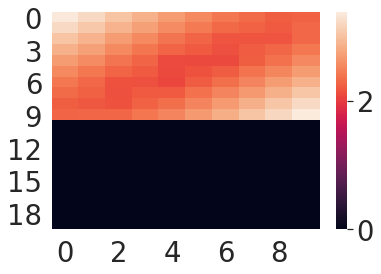

In [25]:
df = df_dict['GC core Ewald 20KL']

x_list = [i for i in range(190)]
plot_arr = np.zeros((20, 10))

for pair in range(100):

    x = int(pair / 10)
    y = pair % 10
    
    pair_avg = np.mean(1/df[str(pair)])
    plot_arr[x, y] = pair_avg

ax = sns.heatmap(plot_arr)
        

In [26]:
## find dot product of leading slow modes for various trim sizes
#df_dict = df_dict_all

# interate through all available slow modes
for EF in EF_list[:n_sm]:
    
    # loop twice through df dict to compare each trim size to each other
    for n1 in df_dict:
        for n2 in df_dict:
            
            # finds slow mode vectors to compare 
            EF1 = df_dict[n1][EF][:500]
            EF2= df_dict[n2][EF][:500]
            
            # takes the dot product of these two vectors
            #print(n1, n2, EF, np.dot(EF1, EF2))
    
# not informative because of varied trim size and skipping



In [27]:
## find pearson coefficients of collective variable

## for AT-all large trim, 1st = inter_all, 2nd = shift_up_2, 3rd = shift_down_2, 4th = shift_up_4, 5th = inter_ends

def cv_to_sm(df, EF_list, cv_list):
    
    print('\n\n')
    
    cv_array = np.zeros((190, len(df['0'])))

    # make cv array for cv_list only
    #for i in range(len(cv_list)):
        #cv_array[i] = df[cv_list[i]]
        #print(cv_list[i], len(df[cv_list[i]]))
    
    # make cv array for all intermolecular distances
    for i in range(100):
        cv_array[i] = df[str(i)]
        #print(cv_list[i], len(df[cv_list[i]]))   
        
    for i in range(len(EF_list)):
        minfo = skm.mutual_info_regression(np.transpose(cv_array), df[EF_list[i]])
        
        # ranks physical coordinates by mutual information to slow mode
        ranked = minfo.argsort()[-100:][::-1]
        #print(EF_list[i], ranked)
        #print(EF_list[i], [round(minfo[i], 3) for i in ranked])
        #for j in range(len(cv_list)):
            #print (EF_list[i], cv_list[j], minfo[j])
        
        data = np.full( (10, 10, 3), 255, dtype=np.uint8 ) 
        fig, ax = plt.subplots(figsize=(10,10))

        ## color pixels for intermolecular
        #for i in range(100):
        for j in ranked:

            x = j % 10 #int(j / 10)
            y = int(j/10) # j % 10
            c = 255 * (1 - minfo[j] / minfo[0])
            
            data[x, y] =  [c, c, c]

        # Create a PIL image
        img = Image.fromarray(data)       

        # set axes and show
        ax.set_xlabel('5 prime strand')
        ax.set_ylabel('3 prime strand')
        ax.set_title(EF_list[i])

        ax.imshow(img)
    
    '''
    for cv in cv_list:
        for EF in EF_list:

            spear, pvals = scipy.stats.spearmanr(df[cv], df[EF])
            pears, pvalp = scipy.stats.pearsonr(df[cv], df[EF])
            
            
            if pvalp < 1:
                #print(EF, '\tcv = ', cv, '\tpearson = ', round(pears, 3), '\tpval = ', pvalp)
                #print(EF, '\tcv = ', cv, '\tmut info = ', minfo)
                pass            
    '''
    
#cv_list = ['inter_all', 'shift_up_2', 'shift_down_2', 'shift_up_4', 'shift_down_4', '9', '90', 'inter_ends', 'inter_cores']

In [28]:
# makes a collection of subplots comparing all plot_list dataframes indices against each other
# color map is determines by the col index
# most readable when len(plot_list) < 7
# function is ideal for comparing many physical coordinates at once and color mapping slowmodes

def plot_subs(df, plot_list, col):
    
    # sets font params and dimensions of subplots
    plt.rcParams.update({'font.size': 32})
    dim = len(plot_list)
    
    tPlot, axes = plt.subplots(
            nrows=dim, ncols=dim, sharex=True, sharey=False, figsize=[40, 40],
            gridspec_kw={'wspace':0.2, 'hspace': 0.2}
            )

    axes_labels = [0 for i in range(dim**2)]
    
    # interates through plot_dict twice and coordinate and plot each coord against the others
    for j, k_i in enumerate(plot_list):
        for i, k_j in enumerate(plot_list):
            
            x = df[k_i]
            y = df[k_j]
            axes_labels[i*dim+j] = [k_i, k_j]
            color = df[col]
            
            sc = axes[i][j].scatter(x, y, c=color, cmap='magma')

    # sets axes such that labels are only on the left and bottom
    for i, ax in enumerate(axes.flat):
        ax.set(xlabel=axes_labels[i][0], ylabel=axes_labels[i][1])
        ax.label_outer()
    
    cbar_ax = tPlot.add_axes([0.95, 0.25, 0.02, 0.5])
    plt.colorbar(sc, cax=cbar_ax, label=col) 
    
    plt.show()
    
    
## plots same x and y axis and color map on 4 different sequences (seperates dataframes)
## takes a list input of the dfs as well as a list of names. ex:

## df_list = [df_all_H, df_end_H, df_mid_H, df_core_H]
## df_name = ['AT_all 326K', 'GC_end 334K', 'GC_mid 342K', 'GC_core 343K']
## plot_4_dfs(df_list, df_name, 'inter_all', 'inter_cores', '1st_EF')

## will plot inter_cores vs inter_all with a color map of the 1st EF for the 4 sequences listed in df_list


def plot_4_dfs(df_list, df_name, x_name, y_name, col):

    plt.rcParams.update({'font.size': 32})
    plt.figure(figsize=(20,20))
    
    cnt = 0

    tPlot, axes = plt.subplots(
                nrows=2, ncols=2, sharex=True, sharey=False, figsize=[40, 40],
                gridspec_kw={'wspace':0.3, 'hspace': 0.3})

    # intialize max values for standard axes
    x_max = 0
    y_max = 0
    pad = 1.05
    t_list = []
        
    for df in df_list:

        # get timescale if using EF as color scale
        c_t = ''
        if col in EF_list:
            c_t = str(round(df['hde_coords'][EF_list.index(col) + 1], 1))
            t_list.append(c_t)
            
        # get x and y and color from named indices in dataframe
        x = df[x_name]
        y = df[y_name]
        color = df[col]
        
        # specify axis on 2x2 grid
        sc = axes[int(cnt / 2)][cnt % 2].scatter(x, y, c=color, cmap='magma')
        
        plt.colorbar(sc, ax=axes[int(cnt / 2)][cnt % 2], label=col)
        cnt += 1

        if max(x) > x_max:
            x_max = max(x)
        if max(y) > y_max:
            y_max = max(y)
    
    # adds outer axes and titles post hoc 
    for i, ax in enumerate(axes.flat):
        title = df_name[i] + ' t = ' + t_list[i]
        ax.set(title=title, xlabel=x_name, ylabel=y_name, xlim=(0, x_max*pad), ylim=(0, y_max*pad))
    
    plt.show()
    

In [29]:
## make a dataframe containing spearman coefficients for all physical distances for each slow mode
## make independent data frame for each df being read in

n_pwd = 190 
df_spear = pd.DataFrame()
df_pvals = pd.DataFrame()

df_pears = pd.DataFrame()
df_pvalp = pd.DataFrame()

for key, df in df_dict.items():
    for j in EF_list[:n_sm]:
        
        spear_list = []
        pvals_list = []
        pears_list = []
        pvalp_list = []
        
        # find spearman and pearson value for each numbered distance
        for i in range(n_pwd):
            
            spear = scipy.stats.spearmanr(df[str(i)], df[j])     
            spear_list.append(spear[0])
            pvals_list.append(spear[1])
            
            pears = scipy.stats.pearsonr(df[str(i)], df[j])
            pears_list.append(pears[0])
            pvalp_list.append(pears[1])
        
        # find spearman and pearson value for each additional named cv
        for cv in {**bp_match_dict, **bp_pairs_dict}:
            
            #print(cv)
            
            spear = scipy.stats.spearmanr(df[cv], df[j])
            spear_list.append(spear[0])
            pvals_list.append(spear[1])
            
            pears = scipy.stats.pearsonr(df[cv], df[j])
            pears_list.append(pears[0])
            pvalp_list.append(pears[1])
            
            
        df_spear[key + ' ' + j] = spear_list
        df_pvals[key + ' ' + j] = pvals_list
        
        df_pears[key + ' ' + j] = pears_list
        df_pvalp[key + ' ' + j] = pvalp_list
    
        #print(key + ' ' + j)
        
#print(df_spear)
            


In [30]:
### plotting spearman coefficients over intermolecular physical coordinates 
def get_rgb(s):
    
    ## color preferences (anything between -254 and 254)
    r = (.5 + .5*s) * 250
    g = (.6 - .4*s) * 200
    b = (.3 - .3*s) * 250
    
    return [r, g, b]
    

def map_spears(df_spear, spear_index, title, df=df_spear):
    
    
    spears = df[spear_index]
    data = np.full( (10, 25, 3), 255, dtype=np.uint8 ) 
    
    fig, ax = plt.subplots(figsize=(20,50))

    ## color pixels for intermolecular
    for i in range(100):

        x = int(i / 10)
        y = i % 10
        s = spears[i]

        #data[x, y] =  [max(255*s, 0),100,max(-255*s, 0)]
        s_256 = .5 + .5*s
        data[x, y] =  get_rgb(s)
        
        if s > 0.9:
            print('s = ', s, ' at pixel: ', title, x, y)
    
    ## color pixels for intramolecular of first strand
    cnt = 100
    for i in range(100):

        x = int(i / 10)
        y = i % 10
        
        if x > y:
            s = spears[cnt]

            #data[x, y] =  [max(255*s, 0),100,max(-255*s, 0)]
            s_256 = .5 + .5*s
            data[x, y + 15] =  get_rgb(s)
            
            cnt += 1 
    
    ## color pixels for intramolecular of second strand
    for i in range(100):

        x = int(i / 10)
        y = i % 10
        
        if x > y:
            s = spears[cnt]

            #data[x, y] =  [max(255*s, 0),100,max(-255*s, 0)]
            s_256 = .5 + .5*s
            data[9 - x, (9 - y) + 15] = get_rgb(s)
            
            cnt += 1 

    ## set scale in middle pixels
    for i in range(10):
        
        s_sc = 1 - .2 * i
        data[i, 12] =  get_rgb(s_sc)
    
    # Create a PIL image
    img = Image.fromarray(data)       
    
    # set axes and show
    ax.set_xlabel('5 prime strand                 scale                intramolecular')
    ax.set_ylabel('3 prime strand')
    ax.set_title(title)
    
    print()
    ax.imshow(img)
           

AT all Ewald 20KL
GC end Ewald 20KL
GC mid Ewald 20KL
GC core Ewald 20KL


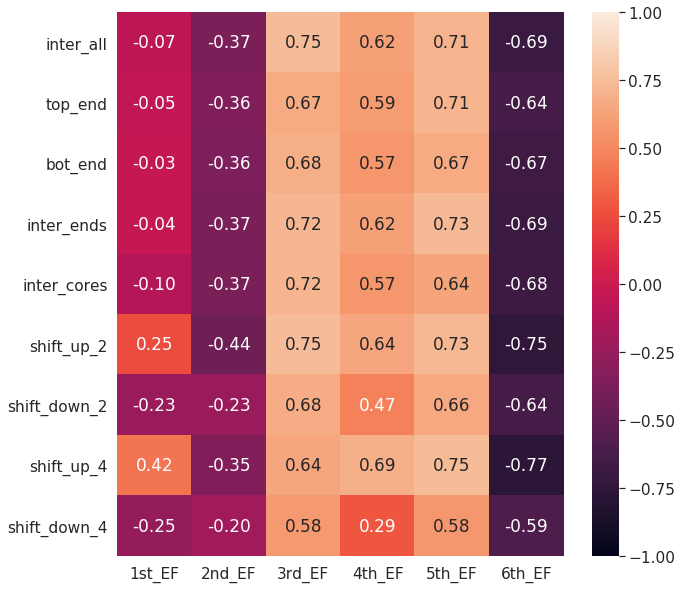

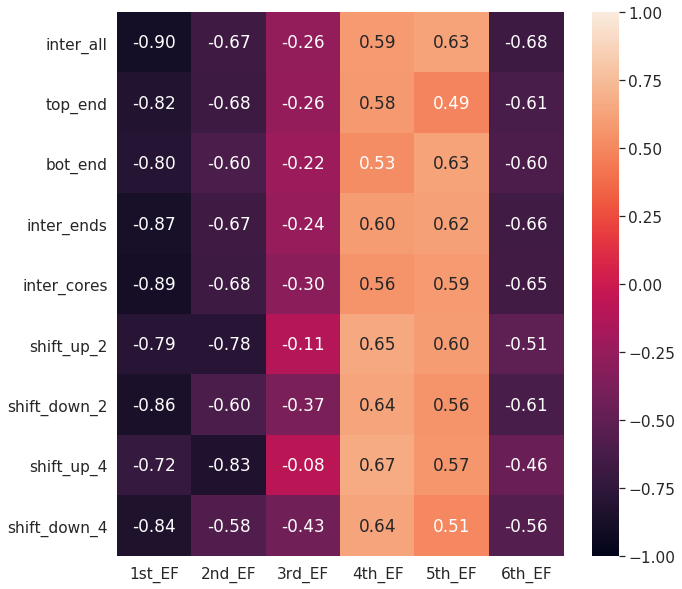

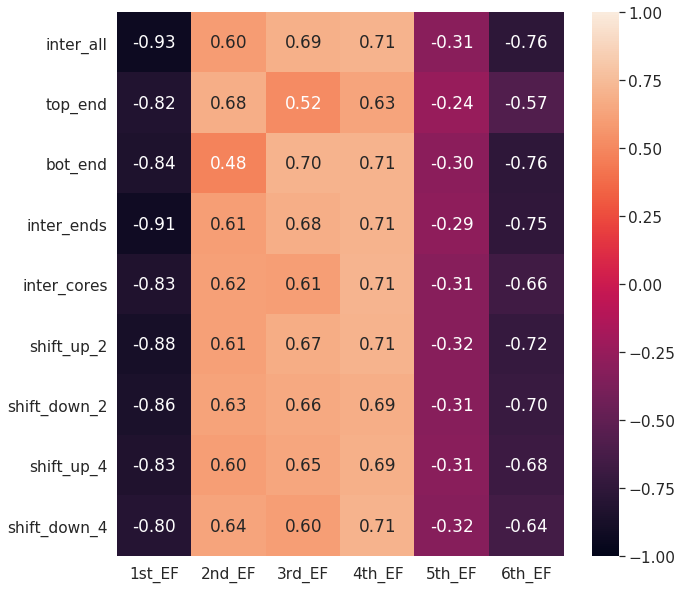

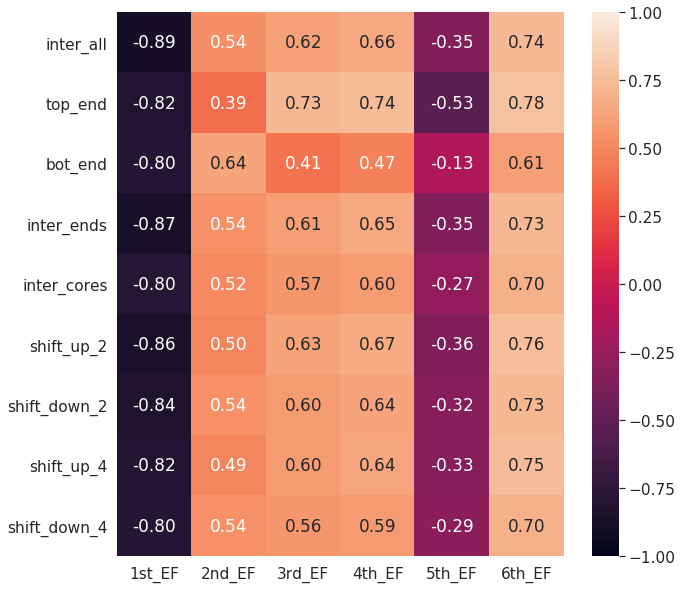

In [31]:
def plot_EF_spears(x_p, y_p, EF, df_name, df_list, spear_list):
    
    spear_list = [name + ' ' + EF for name in spear_list]
    plot_4_dfs(df_list, df_name, x_p, y_p, EF)

    for i in range (len(spear_list)):
        map_spears(df_spear, spear_list[i], df_name[i], df=df_spear)

def spears_table(cv_list, df_name, sm_list, df_corr=df_spear):
    
    sns.set(font_scale=1.4)
    hm_data = np.zeros((len(cv_list), len(sm_list)))
    cv_names = [cv_dict[i] for i in cv_list]
    cnt = 0

    for sm in sm_list:

        key = (df_name + ' ' + sm)
        hm_data[:, cnt] = df_corr[key][cv_list]
        cnt += 1 
            
    f, ax = plt.subplots(figsize=(10, 10))
    
    ax = sns.heatmap(hm_data,  vmin=-1, vmax=1, 
                     xticklabels=sm_list, yticklabels=cv_names, annot=True, fmt='.2f')
    #ax = sns.heatmap(hm_data, xticklabels=sm_list, yticklabels=cv_names)

    
## reference table mapping cvs to locatoin in the spears_dict
cv_dict = {190: 'inter_all',
        191: 'top_end',
        192: 'bot_end',
        193: 'inter_ends',
        194: 'inter_cores',
        195: 'shift_up_2',
        196: 'shift_down_2',
        197: 'shift_up_4',
        198: 'shift_down_4',  
        199: '5prime_shift_2', 
        200: '3prime_shift_2',
        201: '5prime_shift_4',
        202: '3prime_shift_4',
        203: 'top_fray',
        204: 'bot_fray',
        205: 'double_fray'
        }   

cv_list = [(i + 190) for i in range(9)]
#cv_list = [190] + [(i + 199) for i in range(7)]

sm_list = EF_list[:n_sm] 
df_names = ['AT all Ewald 20KL', 'GC end Ewald 20KL', 'GC mid Ewald 20KL', 'GC core Ewald 20KL']

for df_n in df_names:
    print(df_n)
    spears_table(cv_list, df_n, sm_list, df_corr=df_spear)

<Figure size 1440x1440 with 0 Axes>

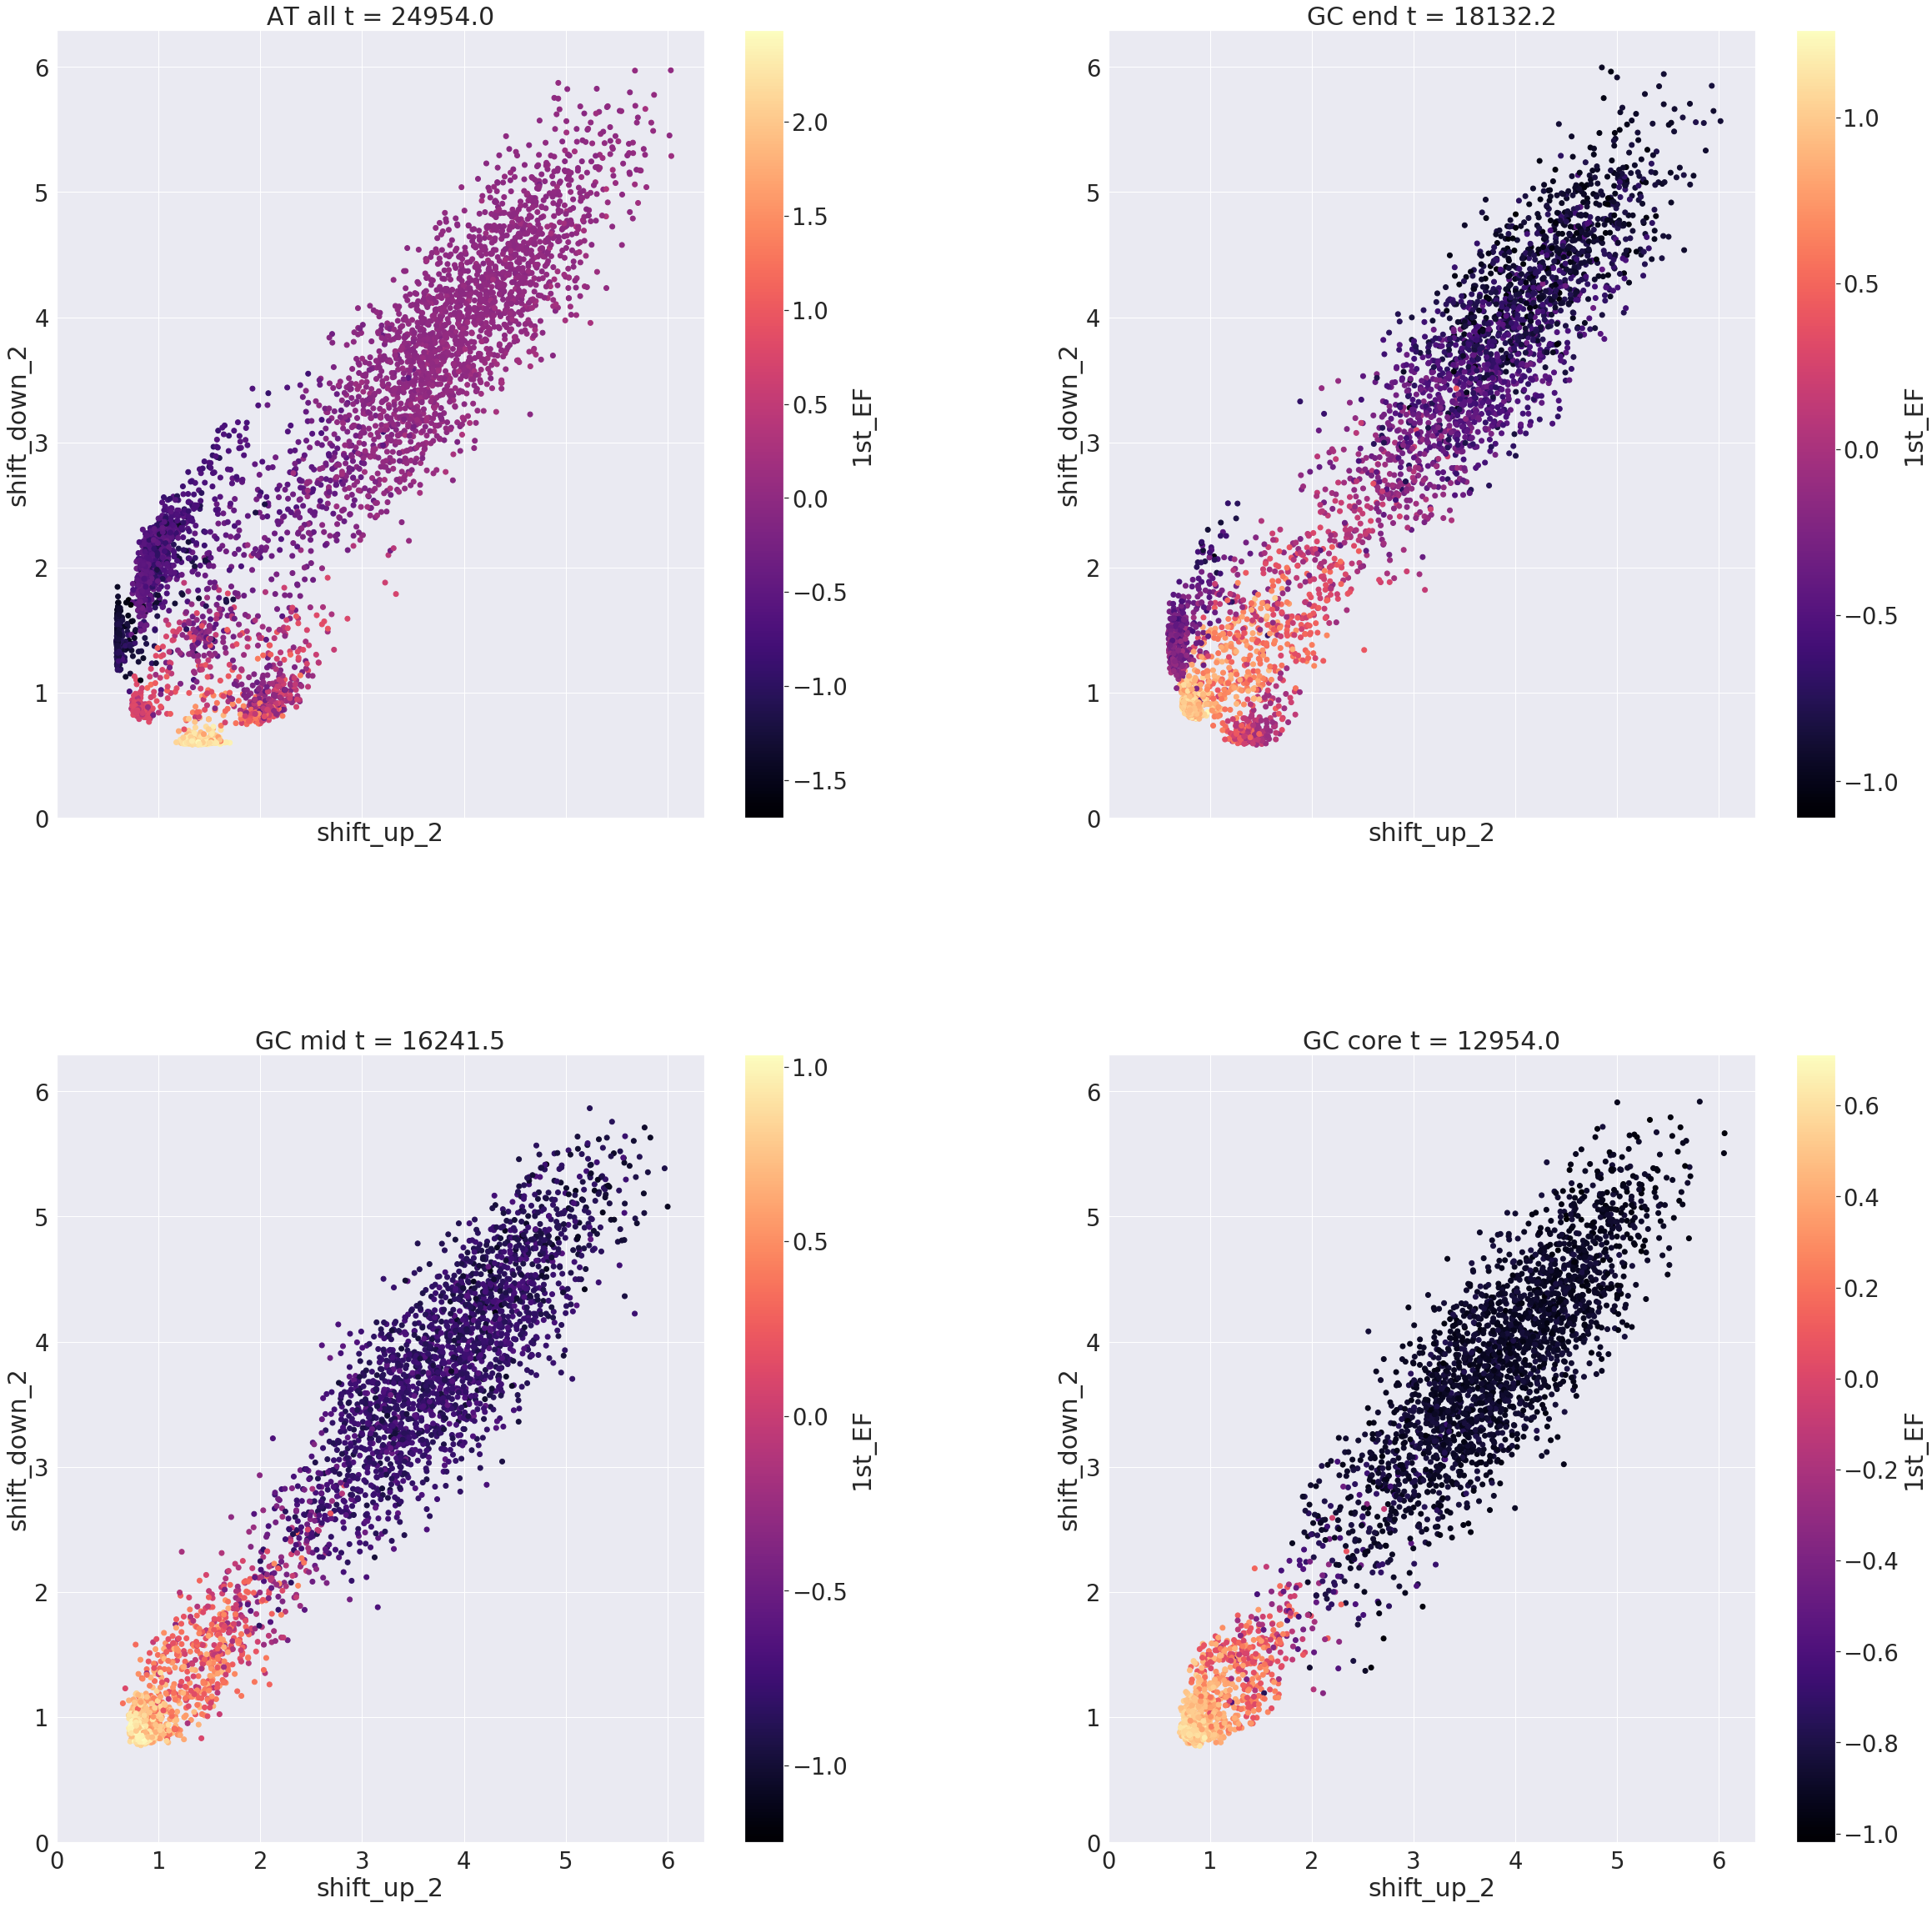

In [33]:
## talk over with andy -- makes plots of all seq Na-only sims
sns.set(font_scale=2.5)
df_name = ['AT all', 'GC end', 'GC mid', 'GC core']

#df_list = [df_all_Na_1krt, df_end_Na_1krt, df_mid_Na_1krt, df_core_Na_1krt]

#df_list = [df_all_Na_16krt, df_end_Na_16krt, df_mid_Na_16krt, df_core_Na_16krt]

#df_list = [df_all_e_ions_us, df_end_e_ions_us, df_mid_e_ions_us, df_core_e_ions_us]

df_list = [df_all_Ewald_20KL_lag100, df_end_Ewald_20KL_lag100, df_mid_Ewald_20KL_lag100, df_core_Ewald_20KL_lag100]

#plot_4_dfs(df_list, df_name, 'inter_all', 'inter_cores', '1st_EF')

plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '1st_EF')

#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '5th_EF')

#plot_4_dfs(df_list, df_name, '9', '90', '3rd_EF')

#plot_4_dfs(df_list, df_name, 'inter_ends', 'inter_cores', '3rd_EF')

<Figure size 1440x1440 with 0 Axes>

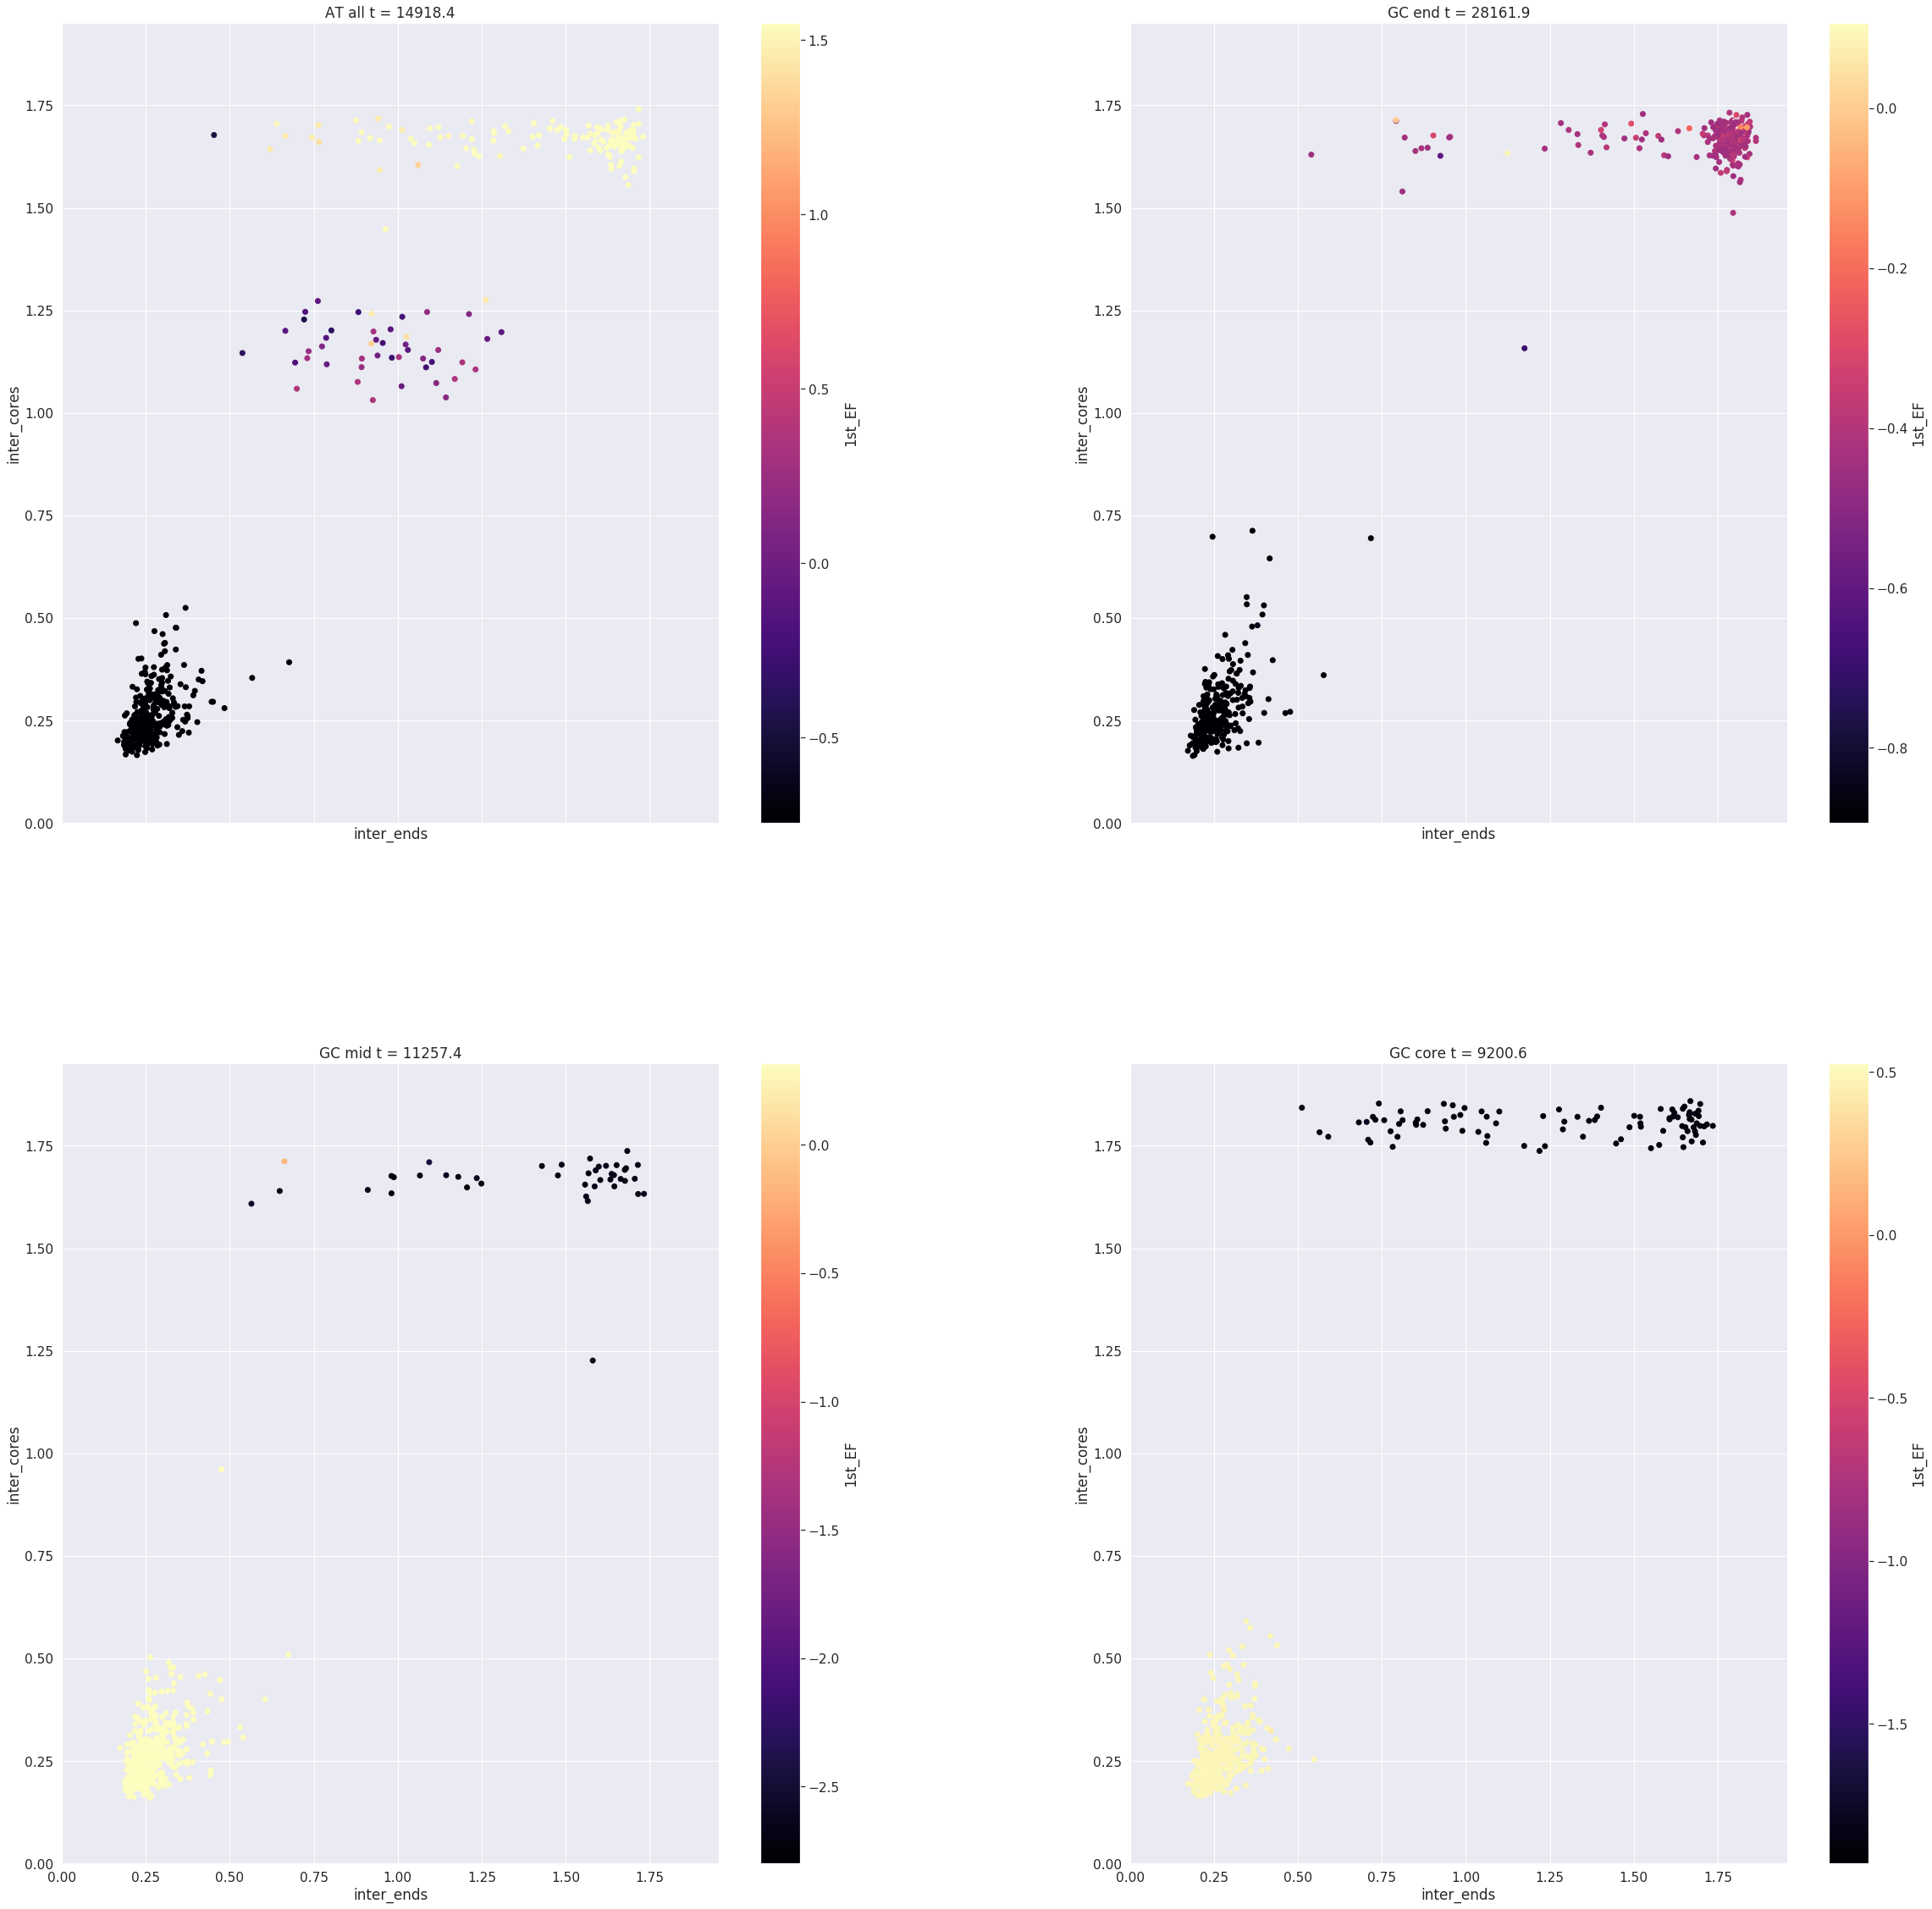

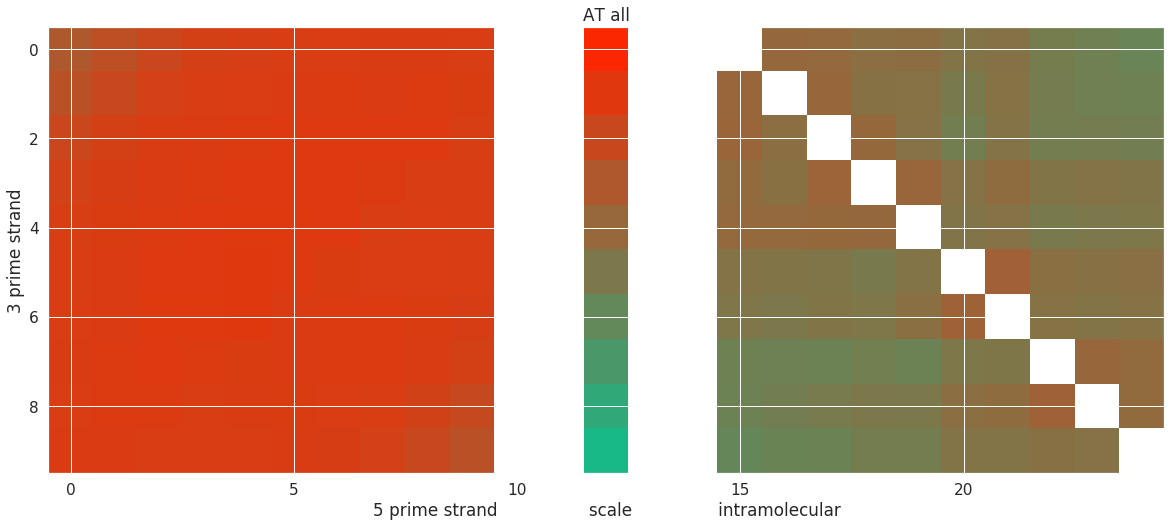

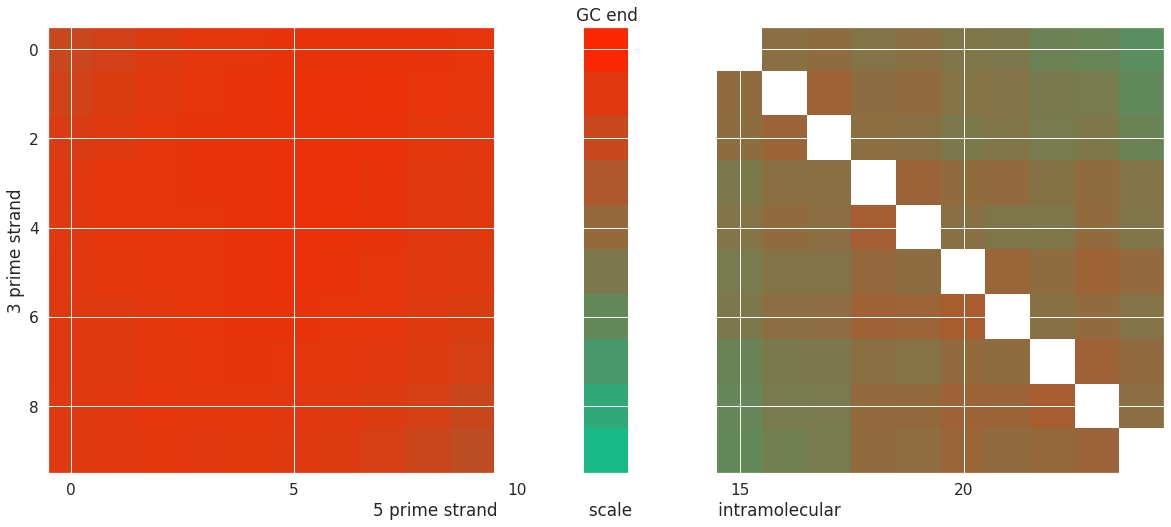

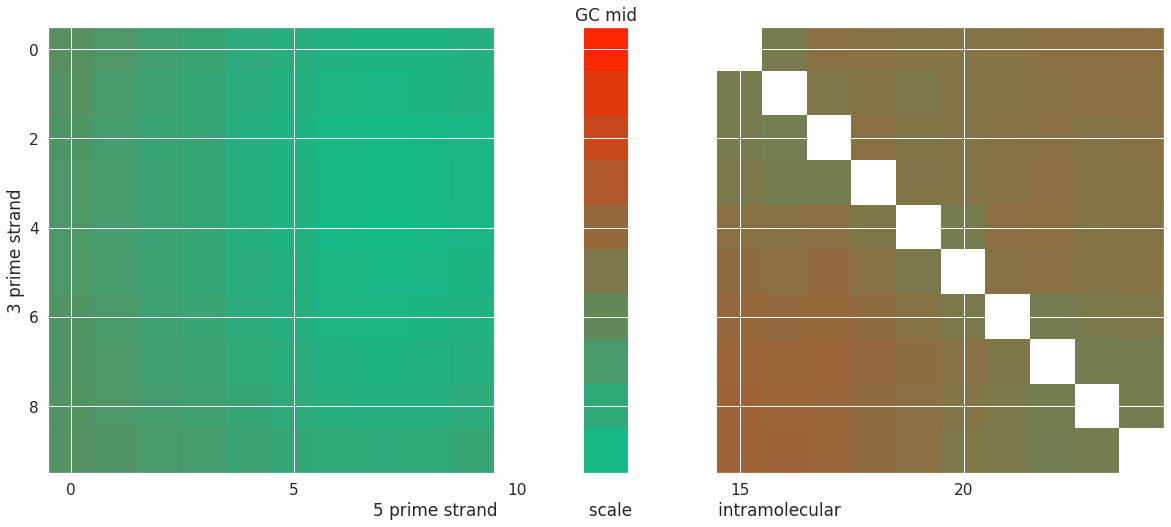

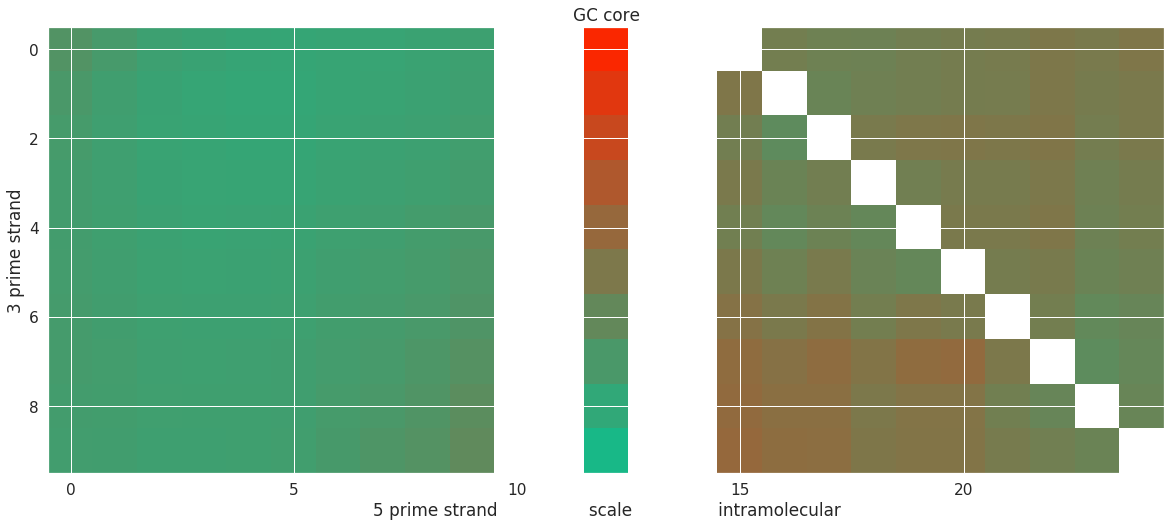

In [34]:
df_name = ['AT all', 'GC end', 'GC mid', 'GC core']

df_list = [df_all_Ewald_equ, df_end_Ewald_equ, df_mid_Ewald_equ, df_core_Ewald_equ]

spear_list = ['AT all Ewald equ', 'GC end Ewald equ', 'GC mid Ewald equ', 'GC core Ewald equ']

plot_EF_spears('inter_ends', 'inter_cores', '1st_EF', df_name, df_list, spear_list)

<Figure size 1440x1440 with 0 Axes>

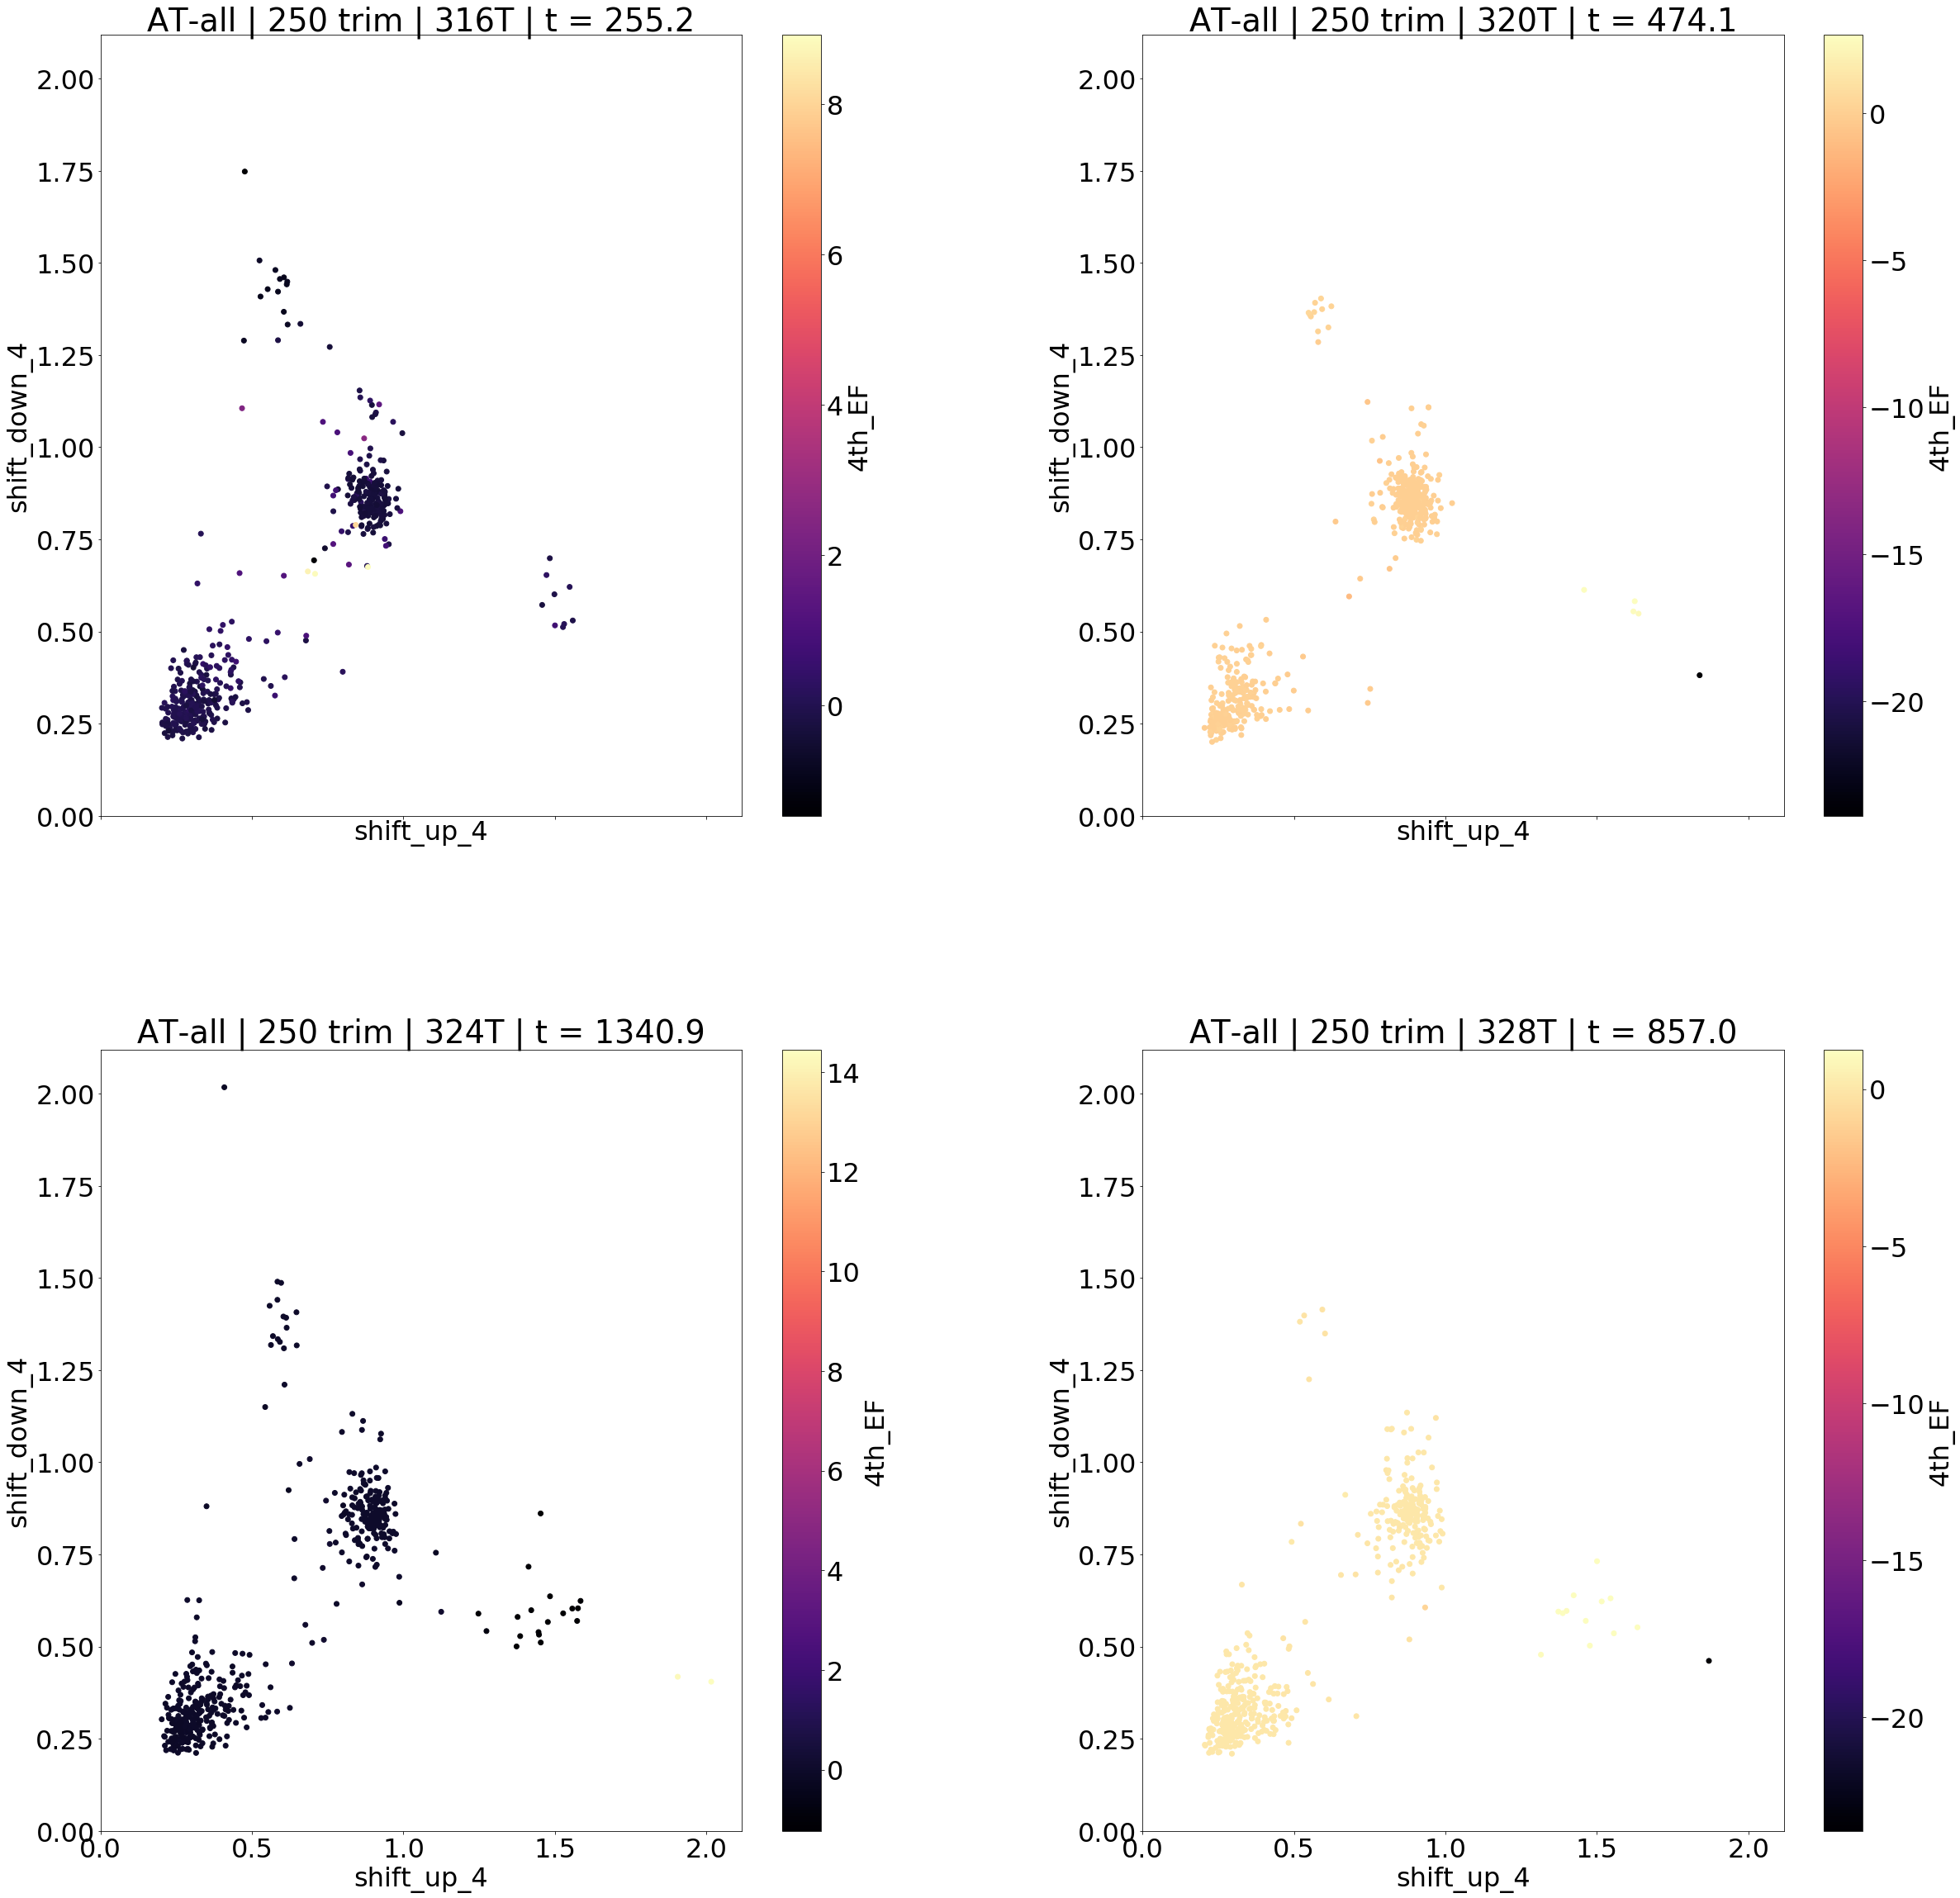

In [42]:
## makes plots of AT-all run at 250 and 16k trims, varied temp from 316 to 328

set_name = 'AT-all | 250 trim | '
temps = [316, 320, 324, 328]
df_name = [set_name+str(temps[i])+'T |' for i in range(len(temps))]

df_list = [df_all_316T_16ktr, df_all_320T_16ktr, df_all_324T_16ktr, df_all_328T_16ktr]

# show first EF
#plot_4_dfs(df_list, df_name, 'inter_all', 'inter_ends', '1st_EF')

#show second EF (shifted)
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '2nd_EF')

#show third EF (shifted)
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

#show fourth EF (shifted 4)
plot_4_dfs(df_list, df_name, 'shift_up_4', 'shift_down_4', '4th_EF')

#show fifth EF
#plot_4_dfs(df_list, df_name, 'shift_up_4', 'shift_down_4', '5th_EF')

# plot AT-all varied temps for 250 trim
#df_list = [df_all_316T_250tr, df_all_320T_250tr, df_all_324T_250tr, df_all_328T_250tr]

# show first EF
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '1st_EF')

# show second EF (fraying)
#plot_4_dfs(df_list, df_name, '9', '90', '2nd_EF')
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '2nd_EF')

# show third EF (shifting)
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

In [100]:
## sets what dfs will be compared, usually compare multiple EF, x_p, y_p for given set of EF
df_name = ['1 ns trim', '4ns trim', '16ns  trim', '64ns trim']
df_list = [df_all_250tr, df_all_1ktr, df_all_4ktr, df_all_16ktr]
spear_list = ['AT all 250tr', 'AT all 1ktr', 'AT all 4ktr', 'AT all 16ktr']


## shows that first SM is consistent for all four
#EF, x_p, y_p = '1st_EF', 'inter_cores', 'inter_ends'

## shows 2nd slow mode depends on fraying symmetry for smaller trims
#EF, x_p, y_p = '2nd_EF', '9', '90'

## shows that there is a preffered shifting direction (up) in order of 2nd and 3rd SM
#EF, x_p, y_p = '2nd_EF', 'shift_up_2', 'shift_down_2'

## directional effect from shifting state comes into play here
#EF, x_p, y_p = '3rd_EF', 'shift_up_2', 'shift_down_2'

## shows 4 ns focus on metastability and shifted 4 state for longer trajs
#EF, x_p, y_p = '4th_EF', 'shift_up_2', 'shift_down_2'
#EF, x_p, y_p = '4th_EF', 'shift_up_4', 'shift_down_4'

## look for lower order patterns at faster slow modes
#EF, x_p, y_p = '6th_EF', '9', '90'

#plot_4_dfs(df_list, df_name, '', '9', '5th_EF')

#plot_EF_spears(x_p, y_p, EF, df_name, df_list, spear_list)


NameError: name 'df_all_250tr' is not defined

In [101]:
## sets what dfs will be compared, usually compare multiple EF, x_p, y_p for given set of EF
df_name = ['1 ns trim', '4ns trim', '16ns  trim', '64ns trim']
df_list = [df_core_250tr, df_core_1ktr, df_core_4ktr, df_core_16ktr]
spear_list = ['GC core 250tr', 'GC core 1ktr', 'GC core 4ktr', 'GC core 16ktr']


## shows that first SM is consistent for all four, much higher correlations than AT-all
#EF, x_p, y_p = '1st_EF', 'inter_cores', 'inter_ends'

## shows 2nd slow mode depends on fraying symmetry for smaller trims, no correlations for longer
#EF, x_p, y_p = '2nd_EF', '9', '90'

## shows core bound frayed state for longer transitions, 45 box clear in pearson maps
EF, x_p, y_p = '2nd_EF', 'inter_cores', 'inter_ends'

## directional effect from shifting state comes into play here
#EF, x_p, y_p = '3rd_EF', '45', '54'

## plot for 4ns after analyzing corresponding pearson map
#EF, x_p, y_p = '3rd_EF', 'inter_all', 'cross_ends'

## two regions of metastabiltiy for the longer trajectories
#EF, x_p, y_p = '4th_EF', 'shift_up_2', 'shift_down_2'

#starts to capture transition to 4 bp shifted state for longer trajectories
#plot_4_dfs(df_list, df_name, 'shift_up_4', 'shift_down_4', '4th_EF')

#plot_EF_spears(x_p, y_p, EF, df_name, df_list, spear_list)

NameError: name 'df_core_250tr' is not defined

In [102]:
## compare 1000 frame trimmed vs full traj for both AT-all and GC-core

## sets what dfs will be compared, usually compare multiple EF, x_p, y_p for given set of EF
df_name = ['AT-all 4ns trim', 'AT-all 64 ns', 'GC-core 4ns trim', 'GC-core 64 ns']
df_list = [df_all_1ktr, df_all_16ktr, df_core_1ktr, df_core_16ktr]
spear_list = ['AT all 1ktr', 'AT all 16ktr', 'GC core 1ktr', 'AT all 16ktr']


## shows that first SM is consistent for all four, much higher correlations than AT-all
#EF, x_p, y_p = '1st_EF', 'inter_cores', 'inter_ends'

## for AT-all and GC-core, second is fraying -- timescales largely depend on absolute temp
#EF, x_p, y_p = '2nd_EF', '9', '90'

## for full AT-all, second is shifting
#EF, x_p, y_p = '2nd_EF', 'shift_up_2', 'shift_down_2'

## for full GC-core, second is metastability -- very short timescales
#EF, x_p, y_p = '2nd_EF', 'inter_cores', 'inter_all'

## shifted states relevant for AT-all but not GC
EF, x_p, y_p = '3rd_EF', 'shift_up_2', 'shift_down_2'

## check inter_cores vs. ends on 3rd EF
#EF, x_p, y_p = '3rd_EF', 'inter_cores', 'inter_all'

## shifted states relevant for AT-all but not GC
#EF, x_p, y_p = '4th_EF', 'shift_up_4', 'shift_down_4'


#plot_EF_spears(x_p, y_p, EF, df_name, df_list, spear_list)

NameError: name 'df_all_1ktr' is not defined

In [104]:
#df = df_core_H

#plot_list = ('1st_EF', '2nd_EF', '3rd_EF', '4th_EF', '5th_EF')
#col = 'inter_all'

#plot_list = ('9', '90', 'inter_ends', 'shift_up_2', 'shift_down_2')
#col = '2nd_EF'


#plot_subs(df, plot_list, col)

In [106]:
df_list = [df_all_250tr, df_all_1ktr, df_all_4ktr, df_all_16ktr]
df_name = ['1 ns trim', '4ns trim', '16ns  trim', '64ns trim']

## shows that first SM is consistent for all four
#plot_4_dfs(df_list, df_name, 'inter_cores', 'inter_ends', '1st_EF')

## shows that 2nd and 3rd slow modes 
#plot_4_dfs(df_list, df_name, '9', '90', '2nd_EF')

## directional effect from shifting state comes into play here
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

## shows 4 ns focus on metastability
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '4th_EF')

## shows that there is a preffered shifting direction (up) in order of 2nd and 3rd SM
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '2nd_EF')
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

## starts to capture transition to 4 bp shifted state for longer trajectories
#plot_4_dfs(df_list, df_name, 'shift_up_4', 'shift_down_4', '4th_EF')


NameError: name 'df_all_250tr' is not defined

In [ ]:
## run by factors of 8 seperations

df_list = [df_core_250tr, df_core_1ktr, df_core_4ktr, df_core_16ktr]
df_name = ['1 ns trim', '8ns trim', '64ns trim', '200ns full']

## shows that first SM is consistent for all four
plot_4_dfs(df_list, df_name, 'inter_cores', 'inter_ends', '2nd_EF')

## shows that 2nd and 3rd slow modes 
#plot_4_dfs(df_list, df_name, '9', '90', '2nd_EF')

## directional effect from shifting state comes into play here
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

## shows 4 ns focus on metastability
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '4th_EF')

## shows that there is a preffered shifting direction (up) in order of 2nd and 3rd SM
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '2nd_EF')
#plot_4_dfs(df_list, df_name, 'shift_up_2', 'shift_down_2', '3rd_EF')

## starts to capture transition to 4 bp shifted state for longer trajectories
#plot_4_dfs(df_list, df_name, 'shift_up_4', 'shift_down_4', '4th_EF')

In [15]:
## shift up 2 vs. shift down 2 for 4 different sequences during dehybridization
## The 3rd EF for GC sequencess identifies metastability, but for AT-all shows shifted transition path

#df_list = [df_all_H, df_end_H, df_mid_H, df_core_H]
#df_name = ['AT_all 326K', 'GC_end 334K', 'GC_mid 342K', 'GC_core 343K']

df_list = [df_all_L, df_end_L, df_mid_L, df_core_L]
df_name = ['AT_all 266K', 'GC_end 274K', 'GC_mid 282K', 'GC_core 283K']

plot_4_dfs(df_list, df_name, '9', '90', '2nd_EF')

NameError: name 'plot_4_dfs' is not defined

<Figure size 1440x1440 with 0 Axes>

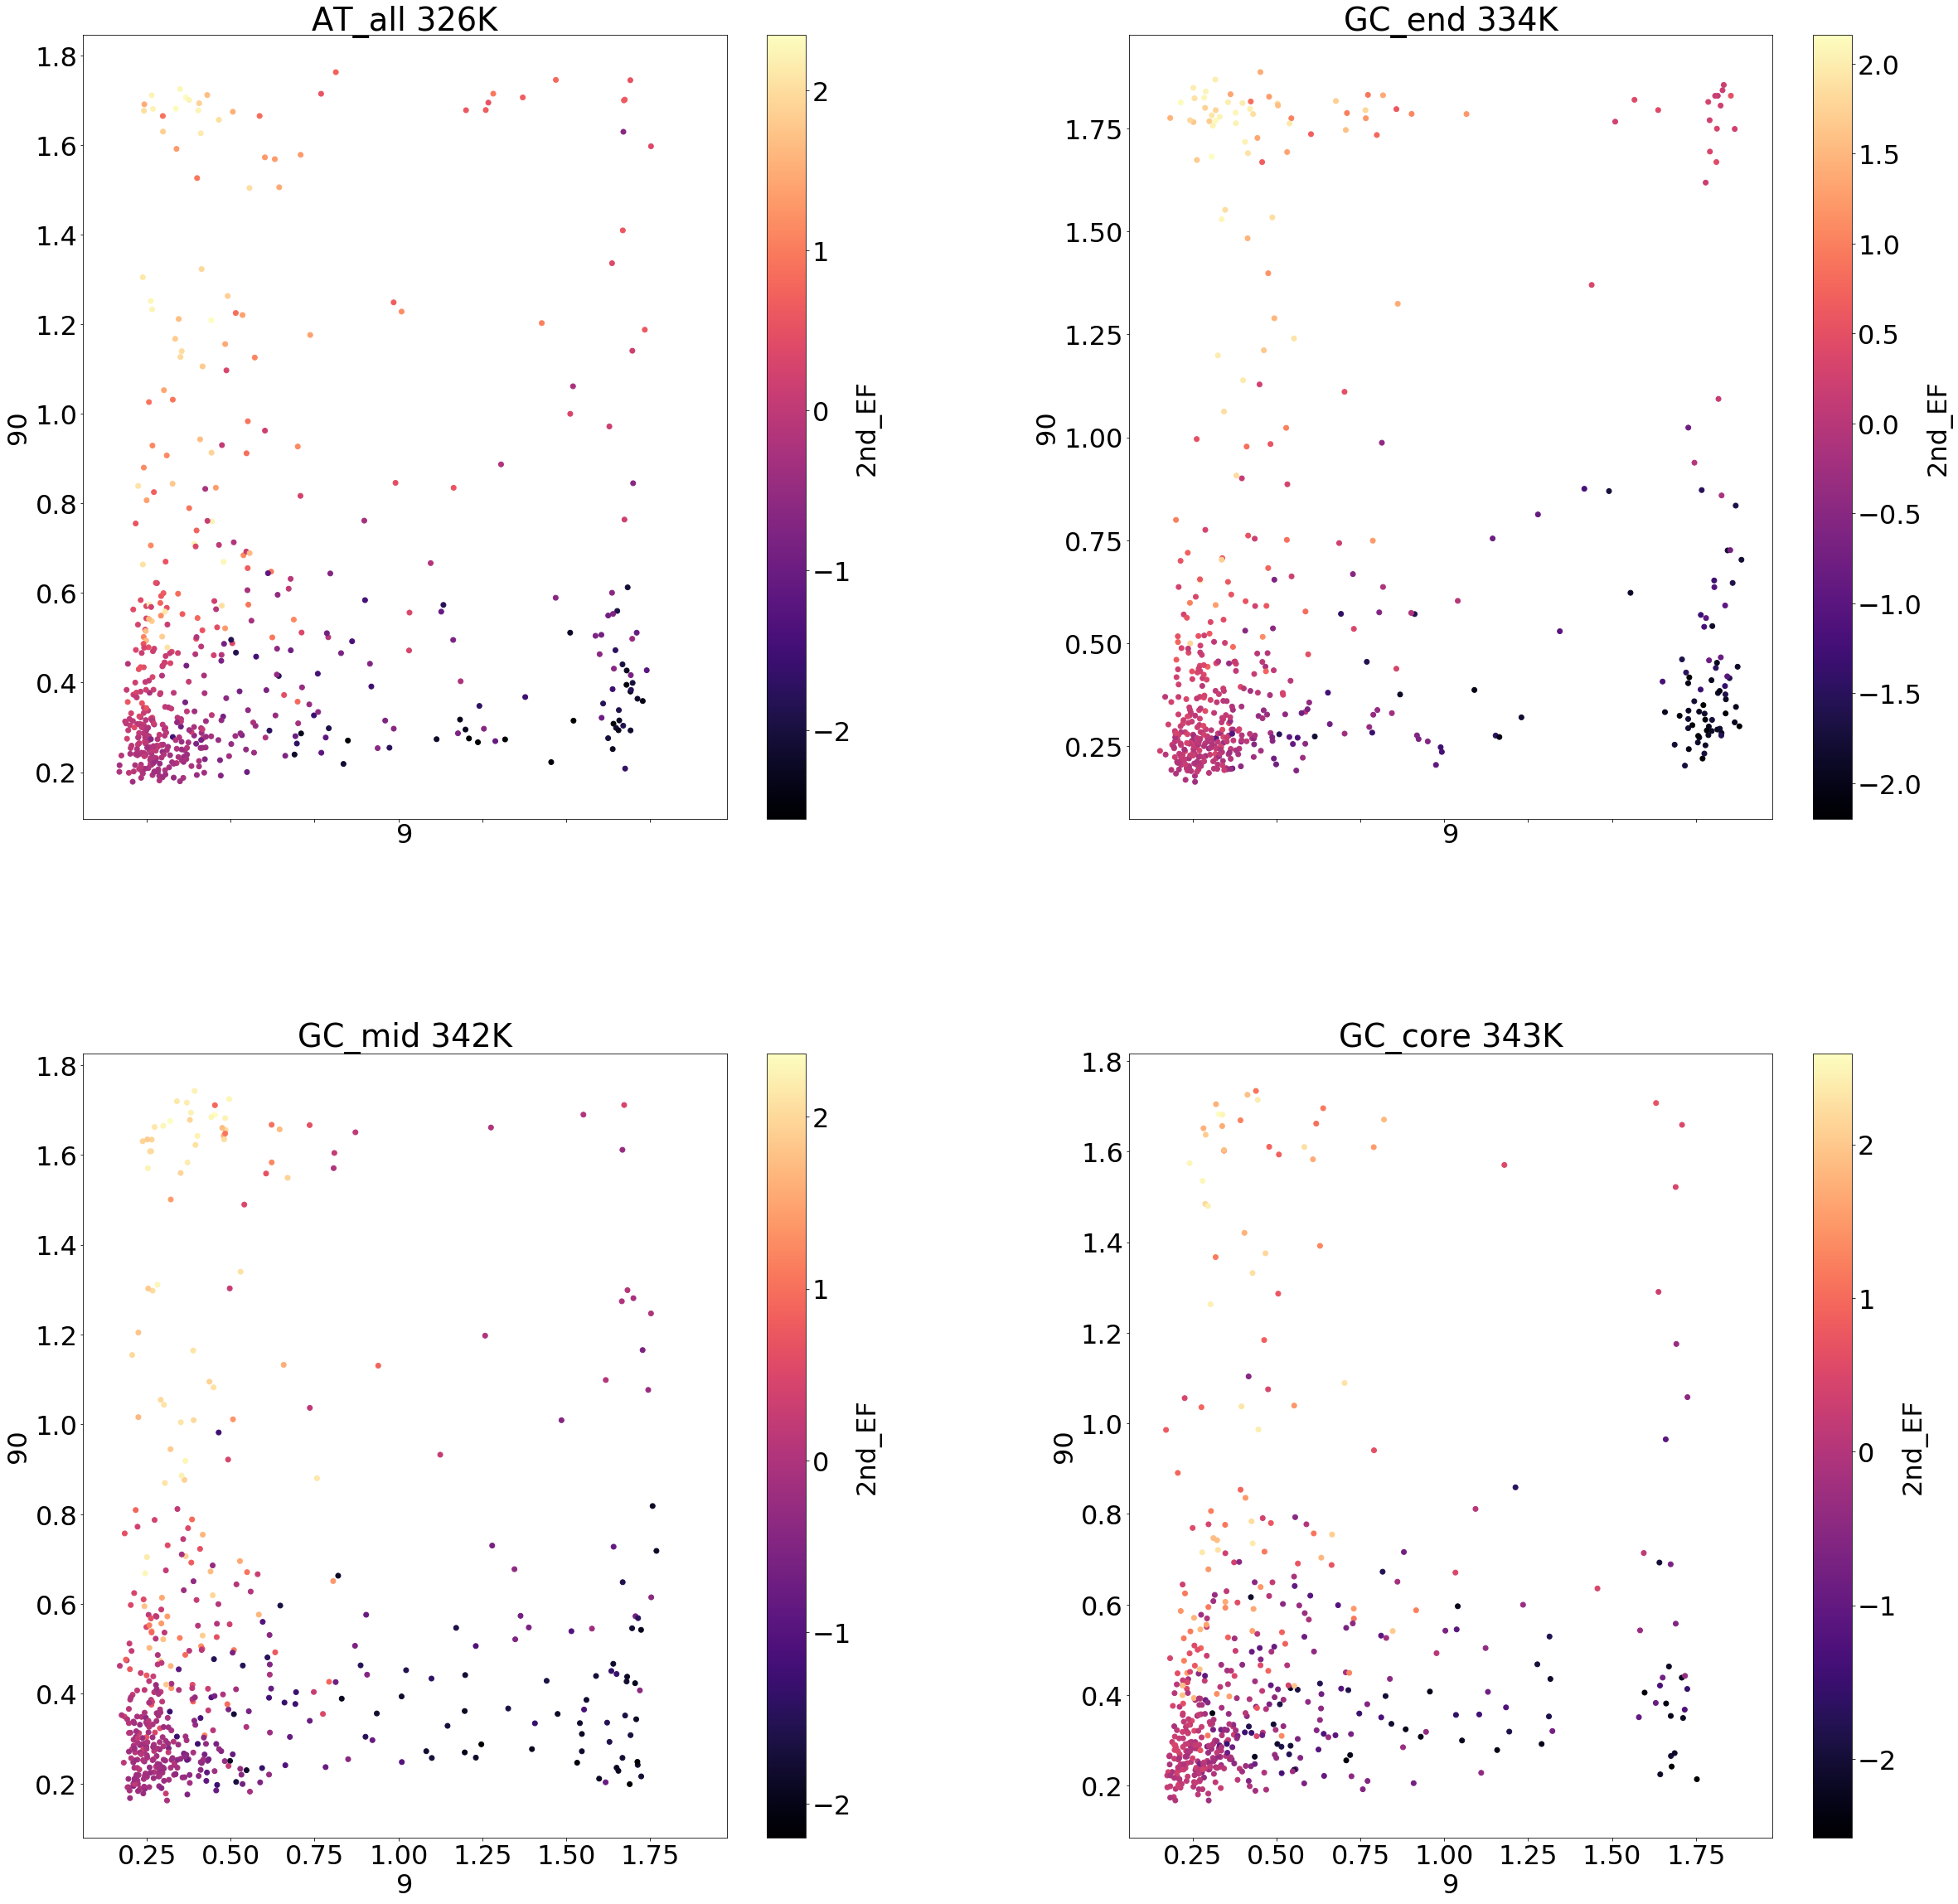

In [49]:
df_list = [df_all_H, df_end_H, df_mid_H, df_core_H]
df_name = ['AT_all 326K', 'GC_end 334K', 'GC_mid 342K', 'GC_core 343K']

#df_list = [df_all_L, df_end_L, df_mid_L, df_core_L]
#df_name = ['AT_all 266K', 'GC_end 274K', 'GC_mid 282K', 'GC_core 283K']

plot_4_dfs(df_list, df_name, '9', '90', '2nd_EF')


In [47]:
#used for looking at individual long trajectories

df = df_end
trajs = 10

row = 2
col = 5

plt.rcParams.update({'font.size': 32})
    
tPlot, axes = plt.subplots(
        nrows=row, ncols=col, sharex=False, sharey=False, figsize=[10*col, 10*row],
        gridspec_kw={'wspace':0.2, 'hspace': 0.2}
        )

# changes df format into list
inter_all_list = df['inter_all'].tolist()
color_list = df['2nd_EF'].tolist()
ts_total = len(inter_all_list)
ts_traj = int(ts_total / trajs)
d_list = []
c_list = []
traj_cnt = 0

# runs through every inter_all value and makes seperate plots for every new traj
for i in range (ts_total):
    
    d_list.append(inter_all_list[i])
    c_list.append(color_list[i])
    
    if (i + 1) % ts_traj == 0:
        
        print (len(d_list))
        x = [j for j in range(i - ts_traj, i)]
        y = d_list
        color = c_list
        
        row_s = int(traj_cnt / col)
        axes[row_s][traj_cnt - col*row_s].scatter(x, y, c=color, cmap='magma')
        
        traj_cnt += 1
        d_list = []
        c_list = []

# set axis title and range limits
for i, ax in enumerate(axes.flat):
    #ax.set(xlabel=axes_labels[i][0], ylabel=axes_labels[i][1])
    ax.set(title="traj " + str(i), xlabel='time', ylabel='inter_all')
    ax.set_ylim([0, 2])
       

NameError: name 'df_end' is not defined